# Example Project for the usage of `Estimator` and `SavedModel`

This project builds a simple Regressor on a publicly available data set to show the proper 
use of `Estimator`s and `SavedModel`s. It is part of the “Enterprise Tensorflow” blog series
on [divis.io]. The goal is to export a Tensorflow Model so it can be run from JAVA.

Even though we do not care much about the performance the code tries to do everything as 
realistically and properly as possible, to showcase the structure of a real (albeit small) 
project.

In [1]:
import tensorflow as tf
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib import mlab
# the following is necessary so plots are displayed in this sheet
%matplotlib inline

# (if you get a runtime warning about a python 3.5/3.6 mismatch you can ignore it, this happens sometimes for TF 1.4
# but can safely be ignored - everything works)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 1. Load and inspect the data, prepare train, validation & test sets

We use the wine quality data set from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). This is the note for using the data: 

> This dataset is public available for research. The details are described in *Cortez et al., 2009*. 
>  Please include this citation if you plan to use this database:
>
>  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
>  # Modeling wine preferences by data mining from physicochemical properties.
>  ## In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
> 
>  Available at: 
>   * [Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
>   * [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
>   * [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

We will perform the following steps: 
 * download the data from the UC Irvine Machine Learning Repository
 * combine the datasets for red and white wine into one dataset with a new attribute `wine_type`
 * create training, validation and test datasets
 * store the newly created datasets

In [2]:
# folder to store training data
folder = 'data/'
# url with the original data from the paper
baseurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# the columns in the resulting CSV (after loading, concatenating, shuffling, etc.)
columns = ['wine_type', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 
           'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 
           'sulphates', 'alcohol', 'quality']
# the input features (everything except last column)
feature_names = columns[:-1]
# all features we need to normalize (everything except wine type)
normalized_feature_names = feature_names[1:]
# what we want to predict (only the last column)
output_features = columns[-1:]

# create target folder if it does not exist
if not os.path.exists(folder): 
    os.makedirs(folder)

# Download the data from the UCI repository, if it does not exist already.
def download_if_not_exists(baseurl, folder, filename): 
    if not os.path.exists(folder + filename): 
        print("File %s does not exist, downloading..." % filename)
        r = requests.get(baseurl + filename)
        with open(folder + filename,'wb') as f:
              f.write(r.content)
    else : 
        print("File %s already exists" % filename)

download_if_not_exists(baseurl, folder, 'winequality.names')    
download_if_not_exists(baseurl, folder, 'winequality-red.csv')    
download_if_not_exists(baseurl, folder, 'winequality-white.csv')    

# now we load the data into two datasets for red and white
red_frame = pd.read_csv(folder + 'winequality-red.csv', sep=';')
white_frame = pd.read_csv(folder + 'winequality-white.csv', sep=';')

# the original paper regards wine types separately, we just turn red & white into 
# a new attribute
red_frame.insert(0, 'wine_type', -1)
white_frame.insert(0, 'wine_type', 1)

# now we can concatenate them into one dataset
frame = pd.concat([red_frame, white_frame])
# free memory for obsolete frames (does not matter for this tiny dataset, 
# but is good practice for when you have many GB)
del red_frame
del white_frame

# now that we have all data in one place, rename columns so everything is lowercase and 
# contains no white spaces - that way, we can later reuse the column names as TF identifiers
new_names = {}
for column in frame: 
    # (add any other name cleanup you need here)
    new_name = column.lower().replace(' ', '_')
    new_names[column] = new_name    
    
frame.rename(columns=new_names, inplace=True)

# we now shuffle the data
frame = frame.sample(frac=1, random_state=196415).reset_index(drop=True)

# Split it into training, validation & testing data (ratio 8:1:1).
frame_length = frame.shape[0]
train_end = int(frame_length * 0.8)
validation_end = train_end + int(frame_length * 0.1)

train_frame = frame.iloc[:train_end].reset_index(drop=True)
validation_frame = frame.iloc[train_end:validation_end].reset_index(drop=True)
test_frame = frame.iloc[validation_end:].reset_index(drop=True)

# free memory
del frame

# Write the resulting sets to CSV files, do not even look at the test data
# from here on!
train_frame.to_csv(folder + 'wine_train.csv')
validation_frame.to_csv(folder + 'wine_validation.csv')
test_frame.to_csv(folder + 'wine_test.csv')
# free memory
del train_frame
del validation_frame
del test_frame

# Note: Depending on the data, stratified sampling may be necessary. We 
# just do random sampling which is enough for the sake of this simple example.
# (we do not strive to achieve a perfect classifier here)
# https://en.wikipedia.org/wiki/Stratified_sampling
# In our case, stratified sampling based on whine type (red / white) and 
# resulting quality might give a better classifier.

File winequality.names already exists
File winequality-red.csv already exists
File winequality-white.csv already exists


# 2. Evaluate training data & determine necessary preprocessing

We now load our prepared data from the previous step. (in a larger project the previous preparation might be done in a separate script, by a different framework, or it might just run a long time so it is useful to save the result and load it later)

We will then visually inspect the data to get some ideas on preprocessing and what we are dealing with. This is partly inspired by a really useful post on [initial visual inspection](https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/)

We will do a quick summary of the data, and have a look at the boxplots to check for extreme outliers. 


In [3]:
train_frame = pd.read_csv(folder + 'wine_train.csv')
# (note we ignore the validation data: we are allowed to use it later for hyperparameter tuning, though)

# we already remove some outliers here that we discovered with the visual inspection 
# (you would normally repeat this a couple of times, we just add the resulting preprocessing 
# here already)
train_frame = train_frame[train_frame['free_sulfur_dioxide'] < 150]
train_frame = train_frame[train_frame['residual_sugar'] < 60]

# quick summary of our values
print(train_frame.describe())

        Unnamed: 0    wine_type  fixed_acidity  volatile_acidity  citric_acid  \
count  5195.000000  5195.000000    5195.000000       5195.000000  5195.000000   
mean   2598.235034     0.514148       7.203725          0.337898     0.317844   
std    1500.432566     0.857784       1.276649          0.163710     0.144414   
min       0.000000    -1.000000       3.800000          0.080000     0.000000   
25%    1299.500000     1.000000       6.400000          0.230000     0.250000   
50%    2598.000000     1.000000       7.000000          0.290000     0.310000   
75%    3897.500000     1.000000       7.700000          0.400000     0.390000   
max    5196.000000     1.000000      15.500000          1.580000     1.660000   

       residual_sugar    chlorides  free_sulfur_dioxide  total_sulfur_dioxide  \
count     5195.000000  5195.000000          5195.000000           5195.000000   
mean         5.453927     0.055532            30.632724            116.168431   
std          4.705693     0

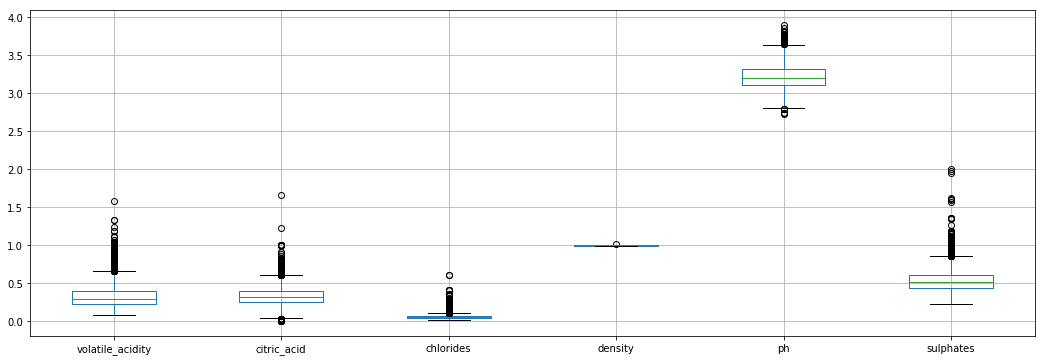

In [4]:
# group values that are approximately in the same range, otherwise the scale is too large to see anything
plot = train_frame[['volatile_acidity', 'citric_acid', 'chlorides', 'density', 'ph', 'sulphates']].boxplot(figsize=(18, 6))

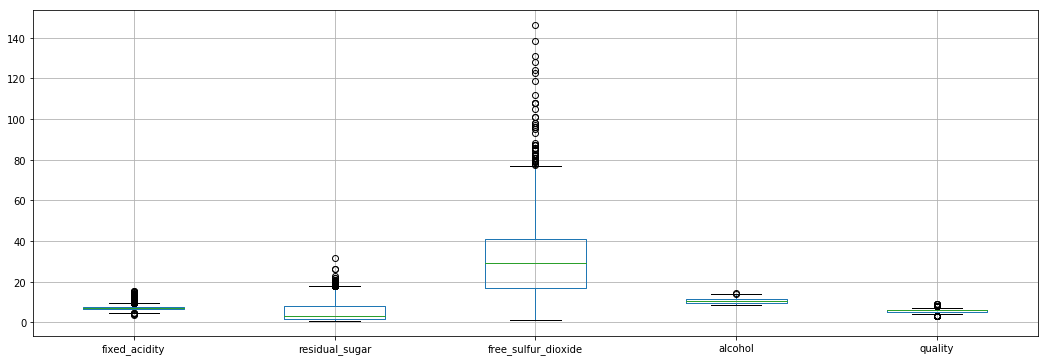

In [5]:
plot = train_frame[['fixed_acidity', 'residual_sugar', 'free_sulfur_dioxide', 'alcohol', 'quality']].boxplot(figsize=(18, 6))


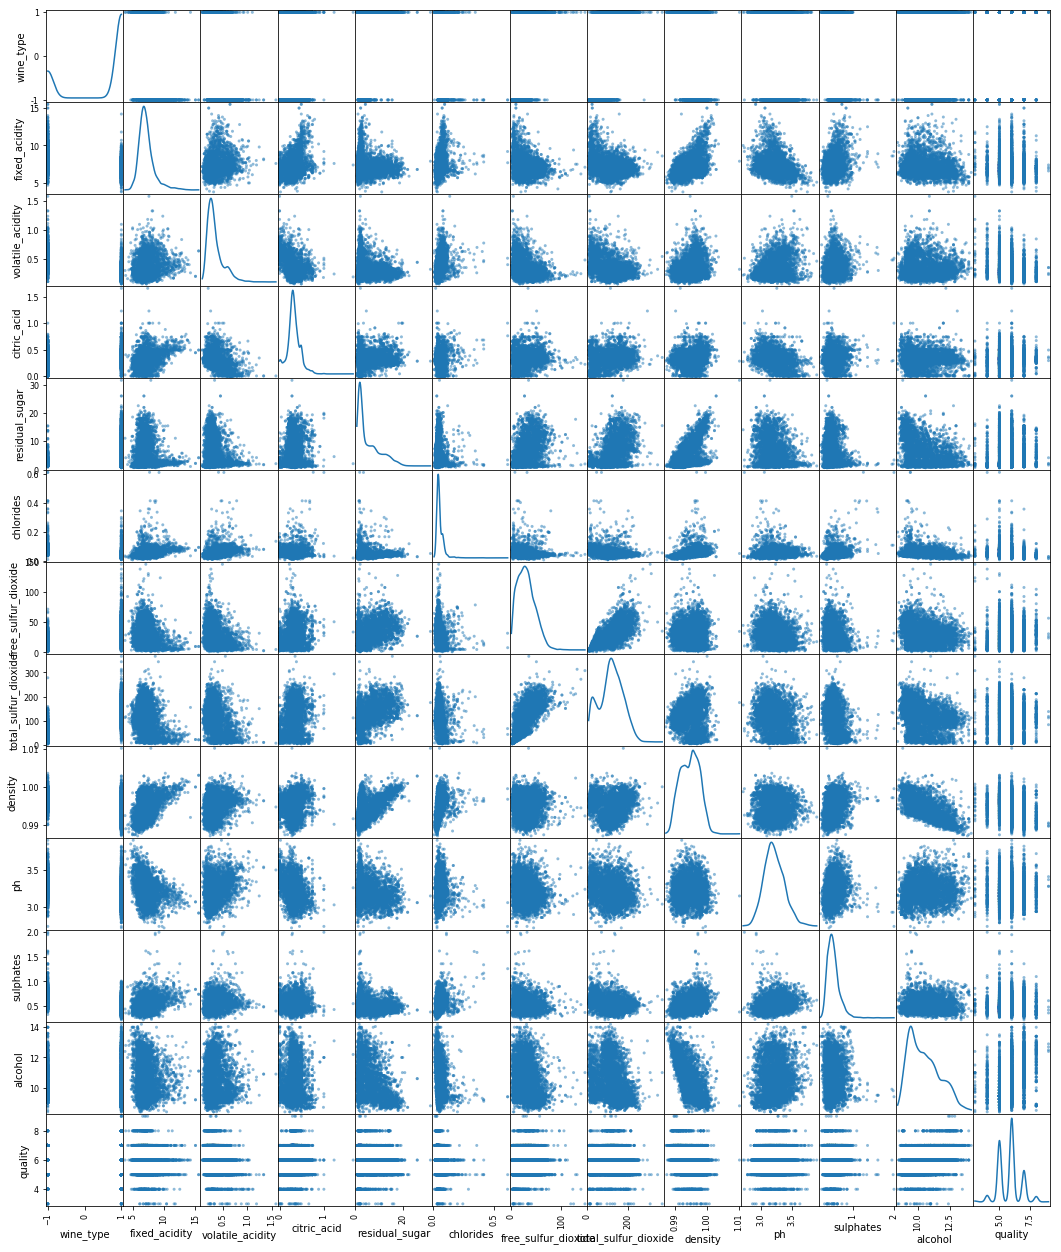

In [6]:
# have a look at the scatter matrix to get an idea how values might be correlated
# we can see that it probably would make sense to leave out volatile acidity, as it does not 
# seem to give us any extra information
plots = pd.plotting.scatter_matrix(train_frame[columns], figsize=(18, 22), diagonal='kde')

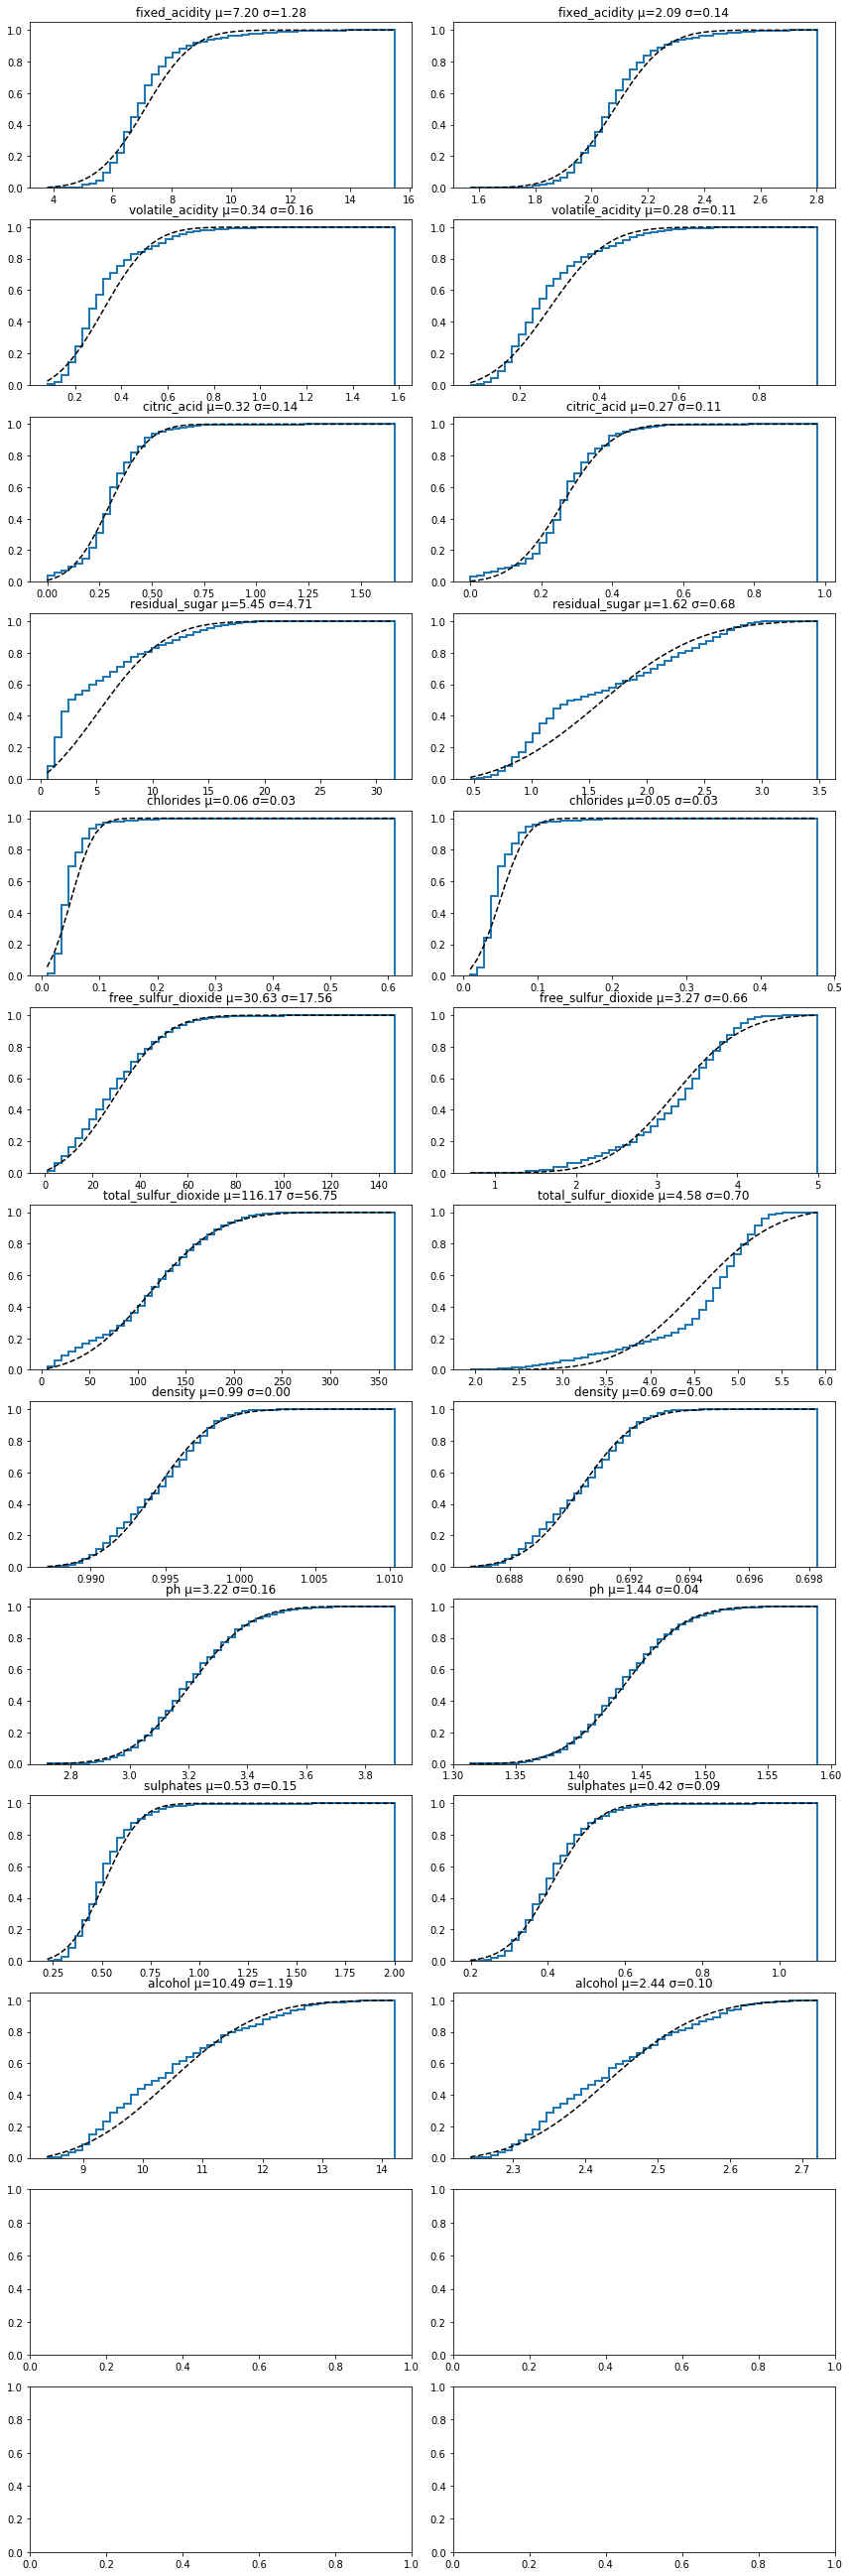

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(12, 36))
fig.tight_layout()

def plot_normalization(title, series, axis): 
    # determine distribution parameters
    mu, sigma = scipy.stats.norm.fit(series)    
    # resolution
    n_bins = 50
    # plot cumulative histogram normed
    n, bins, patches = axis.hist(series, bins=n_bins, normed=1, linewidth=2, histtype='step', cumulative=True, label='Empirical')    
    # Add a line showing the expected distribution.
    y = mlab.normpdf(bins, mu, sigma).cumsum()
    y /= y[-1]
    axis.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')
    # add title and ks test result
    axis.set_title("%s μ=%.2f σ=%.2f" % (column, mu, sigma))
    
# plot CDF for normal distribution and actual distribution to 
# see how well it fits - we also plot the log values to see if 
# taking the logarithm improves things
for idx, column in enumerate(normalized_feature_names): 
    plot_normalization(column, train_frame[column], axes[idx, 0])
    # compare if we get a better fit depending on some transformation
    plot_normalization(column, train_frame[column].apply(lambda x: np.log(x + 1)), axes[idx, 1])
                           
# there might be room for improvement for fixed acidity, volatile acidity, 
# residual sugar or  alcohol, but the plots look well enough for our test, 
# so we will just normalize our values assuming a normal distribution. 

Now we normalize the data so we have a normal distribution around 0 and a standard deviation of 1.
This is not necessary for all learning algorithms, but at least for neural networks. It 
does however not hurt for the other methods, so we just properly do it once, so we can switch
evaluators more easily.

Not all values are always normal distributions, some may have other distributions, so it might be
useful to apply a transformation first and then normalizing them. This is why we had a look at the 
CDFs in the previous step and checked if, for example, a logarithm improves things. For a truly high quality 
model there remains more work to be done, but for a test project our normal distributions should do.

We do not normalize the data directly, we just save the parameters for normalization and let
our Estimator features perform normalization, more on that later.

In [8]:
name_to_normalization = {}

for column in train_frame: 
    mu, sigma = scipy.stats.norm.fit(train_frame[column])    
    min_value = train_frame[column].min()
    max_value = train_frame[column].max()
    name_to_normalization[column] = {"mu": mu, "sigma": sigma, "min": min_value, "max": max_value}
    

# 3. Define input_fn

We use `Evaluator`s, so we need an `input_fn` for training and validation. This is the function that will provide 
the Tensorflow nodes for the input. We will do this by writing a `build_input_fn`-function, that in turn returns another function that actually provides the input - our actual `input_fn`. In Java terms `build_input_fn` is a factory that returns instances of an interface. As python is dynamically typed, the signature for the `input_fn`
is not explicitly defined anywhere except the human readable documentation (and implicitly by the calling code).


In [9]:
# adapted from https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html
# given the small data size, it would be most efficient to put the data into a TF constant now
# instead of loading it from CSV. However in practice you will generally have larger datasets
# and we will use the new datasets API here to show how that would be done.

# The arguments to `build_input_fn` are up to you and depend on each use case.
# We load from CSV, so we need a file_path, we want shuffling for training, 
# we use the epochs to control how long we train.
def build_input_fn(file_path, perform_shuffle=False, epochs=1):
    def decode_csv(line_tensor):
        """Builds nodes that process one line of CSV. The input is *not*
        a string, but a tensor providing the strings when the graph is run.
        We do not parse anything here but build a subgraph that will do the parsing."""
        parsed_line_tensors = tf.decode_csv(line_tensor, [
            [''], # ignore the row counter exported by pandas
            [0.], [0.], [0.], [0.], [0.], 
            [0.], [0.], [0.], [0.], [0.], 
            [0.], [0.], [0.]], 
        name='csv_parser')
        label = parsed_line_tensors[-1:] # Last element is the label
        del parsed_line_tensors[-1] # remove label from list
        features = parsed_line_tensors[1:] # Everything remaining (except first) are the features
        features_and_label = (dict(zip(feature_names, features)), label)
        return features_and_label

    # build a dataset that uses the helper function to parse the input"
    dataset = (tf.data.TextLineDataset(file_path) # create a dataset based on a text file
        .skip(1) # Skip header row"
        .map(decode_csv) # Transform each elem by inserting the result of decode_csv
    )
    # (note that decode_csv is only called once, even if the the name 'map' suggests
    # otherwise: the resulting nodes are inserted in the input pipeline so every
    # input is run through them, "mapped" by them - hence the name)
    
    if perform_shuffle:
        # Randomizes input using a window of 1024 elements (those are read into memory)
        dataset = dataset.shuffle(buffer_size=1024)
        
    dataset = (dataset
        .repeat(epochs) # Repeats dataset this many times
        .batch(64)  # Batch size to use (you could also make this a parameter of `build_input_fn`, 
                    # as this is actually a hyperparameter)
    )

    # now return a function that uses a reference to our dataset to provide new data on each call
    def input_fn(): 
        iterator = dataset.make_one_shot_iterator()
        batch_features, batch_labels = iterator.get_next()
        return batch_features, batch_labels

    return input_fn


In [10]:
# Now we need to define for our Estimators what the input_fn delivers and 
# how to treat / preprocess it. To prevent code duplication, we use a utility
# function to build those definitions
def build_normalizer_fn(feature_name, normalization): 
    def normalizer_fn(tensor): 
        with tf.name_scope(feature_name + '_normalize'): 
            clipped = tf.clip_by_value (tensor, normalization["min"], normalization["max"])
            return (clipped - normalization["mu"]) / normalization["sigma"]
        
    return normalizer_fn

# wine type needs no normalization
feature_columns = [tf.feature_column.numeric_column('wine_type')]
# append all other feature columns with appropriate normalization
for feature_name in normalized_feature_names:     
    feature_columns.append(tf.feature_column.numeric_column(
        feature_name, 
        normalizer_fn = build_normalizer_fn(feature_name, name_to_normalization[feature_name])
    ))
    

In [11]:
# 4. a) Use a pre built linear regression Estimator

# now we try our first model: linear regression using a pre-build estimator
# This might seem boring as Deep Learning is all the rage, but it is always
# a good way to start, as this gives us a baseline of what is quickly achievable
# with simple means. If a neural network does not manage to beat this, it would 
# be overkill.

# with this object we can control the behaviour
# during training - where to save, how often, etc.
linear_runConfig = tf.estimator.RunConfig(
    save_summary_steps=1000,
    # define where to save your checkpoints
    # (model_dir is a confusing name, it should
    # be name checkpoint_dir)
    model_dir="checkpoints_linear",
    # how often to log progress
    log_step_count_steps = 1000
)

linear_regressor = tf.estimator.LinearRegressor(
    # The input features to our model as defined above
   feature_columns=feature_columns, 
   # do not use this parameter - it will only get confusing
   #model_dir=\"../model_dir\") 
   # just use the run config and put everything there
   config = linear_runConfig
)

INFO:tensorflow:Using config: {'_model_dir': 'checkpoints_linear', '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f85d9122cc0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
linear_regressor.train(build_input_fn(folder + 'wine_train.csv', perform_shuffle=True, epochs=1000))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from checkpoints_linear/model.ckpt-81204
INFO:tensorflow:Saving checkpoints for 81205 into checkpoints_linear/model.ckpt.
INFO:tensorflow:loss = 24.1411, step = 81205
INFO:tensorflow:loss = 33.0333, step = 81305 (0.750 sec)
INFO:tensorflow:loss = 29.0862, step = 81405 (0.612 sec)
INFO:tensorflow:loss = 39.223, step = 81505 (0.614 sec)
INFO:tensorflow:loss = 34.6248, step = 81605 (0.549 sec)
INFO:tensorflow:loss = 24.7691, step = 81705 (0.663 sec)
INFO:tensorflow:loss = 31.6789, step = 81805 (0.601 sec)
INFO:tensorflow:loss = 31.2151, step = 81905 (0.603 sec)
INFO:tensorflow:loss = 39.9975, step = 82005 (0.580 sec)
INFO:tensorflow:loss = 39.4525, step = 82105 (0.620 sec)
INFO:tensorflow:global_step/sec: 161.302
INFO:tensorflow:loss = 22.1566, step = 82205 (0.610 sec)
INFO:tensorflow:loss = 36.1691, step = 82305 (0.609 sec)
INFO:tensorflow:loss = 33.0084, step = 82405 (0.606 sec)
INFO:tensorflow:loss = 40.21

KeyboardInterrupt: 

In [15]:
# now let's see how we do on our validation data
linear_regressor.evaluate(build_input_fn(folder + 'wine_validation.csv', perform_shuffle=False, epochs=1))
# Not bad, we are on average off by 0.57 points, so we can give pretty accurate wine quality estimates!

INFO:tensorflow:Starting evaluation at 2017-12-19-16:34:17
INFO:tensorflow:Restoring parameters from checkpoints_linear/model.ckpt-81205
INFO:tensorflow:Finished evaluation at 2017-12-19-16:34:17
INFO:tensorflow:Saving dict for global step 81205: average_loss = 0.565691, global_step = 81205, loss = 33.3758


{'average_loss': 0.56569129, 'global_step': 81205, 'loss': 33.375786}

In [13]:
# 4. b) Usa a pre built DNN Estimator

# Now we try a deep neural network (DNN) in comparison
dnn_runConfig = tf.estimator.RunConfig(
    save_summary_steps=1000,
    # define where to save your checkpoints
    # (model_dir is a confusing name, it should
    # be name checkpoint_dir)
    model_dir="checkpoints_dnn",
    # how often to log progress
    log_step_count_steps = 1000
)

dnn_regressor = tf.estimator.DNNRegressor(    
    feature_columns=feature_columns, 
    # hyperparameters for the DNN: the layer definition
    hidden_units=[64, 32, 16],
    config = dnn_runConfig
)

INFO:tensorflow:Using config: {'_model_dir': 'checkpoints_dnn', '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f85d1772e48>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [33]:
dnn_regressor.train(build_input_fn(folder + 'wine_train.csv', perform_shuffle=True, epochs=1000))

decode_csv called
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into checkpoints_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into checkpoints_dnn/model.ckpt.


INFO:tensorflow:loss = 2459.13, step = 1


INFO:tensorflow:loss = 2459.13, step = 1


INFO:tensorflow:loss = 43.084, step = 101 (0.726 sec)


INFO:tensorflow:loss = 43.084, step = 101 (0.726 sec)


INFO:tensorflow:loss = 39.7229, step = 201 (0.619 sec)


INFO:tensorflow:loss = 39.7229, step = 201 (0.619 sec)


INFO:tensorflow:loss = 32.1745, step = 301 (0.608 sec)


INFO:tensorflow:loss = 32.1745, step = 301 (0.608 sec)


INFO:tensorflow:loss = 30.7575, step = 401 (0.548 sec)


INFO:tensorflow:loss = 30.7575, step = 401 (0.548 sec)


INFO:tensorflow:loss = 31.2647, step = 501 (0.657 sec)


INFO:tensorflow:loss = 31.2647, step = 501 (0.657 sec)


INFO:tensorflow:loss = 34.6651, step = 601 (0.602 sec)


INFO:tensorflow:loss = 34.6651, step = 601 (0.602 sec)


INFO:tensorflow:loss = 25.5585, step = 701 (0.604 sec)


INFO:tensorflow:loss = 25.5585, step = 701 (0.604 sec)


INFO:tensorflow:loss = 26.4299, step = 801 (0.577 sec)


INFO:tensorflow:loss = 26.4299, step = 801 (0.577 sec)


INFO:tensorflow:loss = 51.652, step = 901 (0.625 sec)


INFO:tensorflow:loss = 51.652, step = 901 (0.625 sec)


INFO:tensorflow:global_step/sec: 162.219


INFO:tensorflow:global_step/sec: 162.219


INFO:tensorflow:loss = 28.7083, step = 1001 (0.602 sec)


INFO:tensorflow:loss = 28.7083, step = 1001 (0.602 sec)


INFO:tensorflow:loss = 38.3459, step = 1101 (0.606 sec)


INFO:tensorflow:loss = 38.3459, step = 1101 (0.606 sec)


INFO:tensorflow:loss = 24.2291, step = 1201 (0.608 sec)


INFO:tensorflow:loss = 24.2291, step = 1201 (0.608 sec)


INFO:tensorflow:loss = 35.9053, step = 1301 (0.607 sec)


INFO:tensorflow:loss = 35.9053, step = 1301 (0.607 sec)


INFO:tensorflow:loss = 40.1224, step = 1401 (0.604 sec)


INFO:tensorflow:loss = 40.1224, step = 1401 (0.604 sec)


INFO:tensorflow:loss = 23.4252, step = 1501 (0.609 sec)


INFO:tensorflow:loss = 23.4252, step = 1501 (0.609 sec)


INFO:tensorflow:loss = 20.7299, step = 1601 (0.606 sec)


INFO:tensorflow:loss = 20.7299, step = 1601 (0.606 sec)


INFO:tensorflow:loss = 29.2548, step = 1701 (0.546 sec)


INFO:tensorflow:loss = 29.2548, step = 1701 (0.546 sec)


INFO:tensorflow:loss = 29.6821, step = 1801 (0.662 sec)


INFO:tensorflow:loss = 29.6821, step = 1801 (0.662 sec)


INFO:tensorflow:loss = 30.2567, step = 1901 (0.601 sec)


INFO:tensorflow:loss = 30.2567, step = 1901 (0.601 sec)


INFO:tensorflow:global_step/sec: 165.206


INFO:tensorflow:global_step/sec: 165.206


INFO:tensorflow:loss = 22.0581, step = 2001 (0.606 sec)


INFO:tensorflow:loss = 22.0581, step = 2001 (0.606 sec)


INFO:tensorflow:loss = 29.7735, step = 2101 (0.575 sec)


INFO:tensorflow:loss = 29.7735, step = 2101 (0.575 sec)


INFO:tensorflow:loss = 25.769, step = 2201 (0.629 sec)


INFO:tensorflow:loss = 25.769, step = 2201 (0.629 sec)


INFO:tensorflow:loss = 25.221, step = 2301 (0.607 sec)


INFO:tensorflow:loss = 25.221, step = 2301 (0.607 sec)


INFO:tensorflow:loss = 30.0589, step = 2401 (0.605 sec)


INFO:tensorflow:loss = 30.0589, step = 2401 (0.605 sec)


INFO:tensorflow:loss = 22.8914, step = 2501 (0.607 sec)


INFO:tensorflow:loss = 22.8914, step = 2501 (0.607 sec)


INFO:tensorflow:loss = 30.5655, step = 2601 (0.602 sec)


INFO:tensorflow:loss = 30.5655, step = 2601 (0.602 sec)


INFO:tensorflow:loss = 33.2437, step = 2701 (0.597 sec)


INFO:tensorflow:loss = 33.2437, step = 2701 (0.597 sec)


INFO:tensorflow:loss = 28.8237, step = 2801 (0.605 sec)


INFO:tensorflow:loss = 28.8237, step = 2801 (0.605 sec)


INFO:tensorflow:loss = 23.4871, step = 2901 (0.600 sec)


INFO:tensorflow:loss = 23.4871, step = 2901 (0.600 sec)


INFO:tensorflow:global_step/sec: 167.413


INFO:tensorflow:global_step/sec: 167.413


INFO:tensorflow:loss = 30.0383, step = 3001 (0.547 sec)


INFO:tensorflow:loss = 30.0383, step = 3001 (0.547 sec)


INFO:tensorflow:loss = 18.3765, step = 3101 (0.671 sec)


INFO:tensorflow:loss = 18.3765, step = 3101 (0.671 sec)


INFO:tensorflow:loss = 28.4543, step = 3201 (0.606 sec)


INFO:tensorflow:loss = 28.4543, step = 3201 (0.606 sec)


INFO:tensorflow:loss = 17.2838, step = 3301 (0.600 sec)


INFO:tensorflow:loss = 17.2838, step = 3301 (0.600 sec)


INFO:tensorflow:loss = 21.2464, step = 3401 (0.571 sec)


INFO:tensorflow:loss = 21.2464, step = 3401 (0.571 sec)


INFO:tensorflow:loss = 21.5191, step = 3501 (0.632 sec)


INFO:tensorflow:loss = 21.5191, step = 3501 (0.632 sec)


INFO:tensorflow:loss = 28.881, step = 3601 (0.610 sec)


INFO:tensorflow:loss = 28.881, step = 3601 (0.610 sec)


INFO:tensorflow:loss = 25.6292, step = 3701 (0.609 sec)


INFO:tensorflow:loss = 25.6292, step = 3701 (0.609 sec)


INFO:tensorflow:loss = 30.8582, step = 3801 (0.602 sec)


INFO:tensorflow:loss = 30.8582, step = 3801 (0.602 sec)


INFO:tensorflow:loss = 27.5993, step = 3901 (0.599 sec)


INFO:tensorflow:loss = 27.5993, step = 3901 (0.599 sec)


INFO:tensorflow:global_step/sec: 163.758


INFO:tensorflow:global_step/sec: 163.758


INFO:tensorflow:loss = 29.0359, step = 4001 (0.606 sec)


INFO:tensorflow:loss = 29.0359, step = 4001 (0.606 sec)


INFO:tensorflow:loss = 26.7327, step = 4101 (0.596 sec)


INFO:tensorflow:loss = 26.7327, step = 4101 (0.596 sec)


INFO:tensorflow:loss = 20.3054, step = 4201 (0.601 sec)


INFO:tensorflow:loss = 20.3054, step = 4201 (0.601 sec)


INFO:tensorflow:loss = 33.5861, step = 4301 (0.536 sec)


INFO:tensorflow:loss = 33.5861, step = 4301 (0.536 sec)


INFO:tensorflow:loss = 20.3755, step = 4401 (0.674 sec)


INFO:tensorflow:loss = 20.3755, step = 4401 (0.674 sec)


INFO:tensorflow:loss = 23.3597, step = 4501 (0.614 sec)


INFO:tensorflow:loss = 23.3597, step = 4501 (0.614 sec)


INFO:tensorflow:loss = 35.0353, step = 4601 (0.603 sec)


INFO:tensorflow:loss = 35.0353, step = 4601 (0.603 sec)


INFO:tensorflow:loss = 23.2402, step = 4701 (0.562 sec)


INFO:tensorflow:loss = 23.2402, step = 4701 (0.562 sec)


INFO:tensorflow:loss = 18.3865, step = 4801 (0.644 sec)


INFO:tensorflow:loss = 18.3865, step = 4801 (0.644 sec)


INFO:tensorflow:loss = 35.467, step = 4901 (0.608 sec)


INFO:tensorflow:loss = 35.467, step = 4901 (0.608 sec)


INFO:tensorflow:global_step/sec: 165.34


INFO:tensorflow:global_step/sec: 165.34


INFO:tensorflow:loss = 27.6841, step = 5001 (0.612 sec)


INFO:tensorflow:loss = 27.6841, step = 5001 (0.612 sec)


INFO:tensorflow:loss = 21.9562, step = 5101 (0.598 sec)


INFO:tensorflow:loss = 21.9562, step = 5101 (0.598 sec)


INFO:tensorflow:loss = 22.962, step = 5201 (0.611 sec)


INFO:tensorflow:loss = 22.962, step = 5201 (0.611 sec)


INFO:tensorflow:loss = 29.9327, step = 5301 (0.605 sec)


INFO:tensorflow:loss = 29.9327, step = 5301 (0.605 sec)


INFO:tensorflow:loss = 23.7019, step = 5401 (0.602 sec)


INFO:tensorflow:loss = 23.7019, step = 5401 (0.602 sec)


INFO:tensorflow:loss = 21.8283, step = 5501 (0.600 sec)


INFO:tensorflow:loss = 21.8283, step = 5501 (0.600 sec)


INFO:tensorflow:loss = 25.3662, step = 5601 (0.541 sec)


INFO:tensorflow:loss = 25.3662, step = 5601 (0.541 sec)


INFO:tensorflow:loss = 42.7594, step = 5701 (0.675 sec)


INFO:tensorflow:loss = 42.7594, step = 5701 (0.675 sec)


INFO:tensorflow:loss = 32.3444, step = 5801 (0.603 sec)


INFO:tensorflow:loss = 32.3444, step = 5801 (0.603 sec)


INFO:tensorflow:loss = 20.0377, step = 5901 (0.603 sec)


INFO:tensorflow:loss = 20.0377, step = 5901 (0.603 sec)


INFO:tensorflow:global_step/sec: 166.451


INFO:tensorflow:global_step/sec: 166.451


INFO:tensorflow:loss = 12.3818, step = 6001 (0.570 sec)


INFO:tensorflow:loss = 12.3818, step = 6001 (0.570 sec)


INFO:tensorflow:loss = 22.6778, step = 6101 (0.641 sec)


INFO:tensorflow:loss = 22.6778, step = 6101 (0.641 sec)


INFO:tensorflow:loss = 19.0589, step = 6201 (0.610 sec)


INFO:tensorflow:loss = 19.0589, step = 6201 (0.610 sec)


INFO:tensorflow:loss = 21.0026, step = 6301 (0.602 sec)


INFO:tensorflow:loss = 21.0026, step = 6301 (0.602 sec)


INFO:tensorflow:loss = 28.4102, step = 6401 (0.594 sec)


INFO:tensorflow:loss = 28.4102, step = 6401 (0.594 sec)


INFO:tensorflow:loss = 21.2929, step = 6501 (0.614 sec)


INFO:tensorflow:loss = 21.2929, step = 6501 (0.614 sec)


INFO:tensorflow:loss = 26.0124, step = 6601 (0.605 sec)


INFO:tensorflow:loss = 26.0124, step = 6601 (0.605 sec)


INFO:tensorflow:loss = 14.9854, step = 6701 (0.607 sec)


INFO:tensorflow:loss = 14.9854, step = 6701 (0.607 sec)


INFO:tensorflow:loss = 20.2918, step = 6801 (0.600 sec)


INFO:tensorflow:loss = 20.2918, step = 6801 (0.600 sec)


INFO:tensorflow:loss = 20.682, step = 6901 (0.526 sec)


INFO:tensorflow:loss = 20.682, step = 6901 (0.526 sec)


INFO:tensorflow:global_step/sec: 164.451


INFO:tensorflow:global_step/sec: 164.451


INFO:tensorflow:loss = 20.4277, step = 7001 (0.682 sec)


INFO:tensorflow:loss = 20.4277, step = 7001 (0.682 sec)


INFO:tensorflow:loss = 26.3778, step = 7101 (0.608 sec)


INFO:tensorflow:loss = 26.3778, step = 7101 (0.608 sec)


INFO:tensorflow:loss = 24.8393, step = 7201 (0.605 sec)


INFO:tensorflow:loss = 24.8393, step = 7201 (0.605 sec)


INFO:tensorflow:loss = 21.6099, step = 7301 (0.569 sec)


INFO:tensorflow:loss = 21.6099, step = 7301 (0.569 sec)


INFO:tensorflow:loss = 19.1958, step = 7401 (0.647 sec)


INFO:tensorflow:loss = 19.1958, step = 7401 (0.647 sec)


INFO:tensorflow:loss = 29.4603, step = 7501 (0.607 sec)


INFO:tensorflow:loss = 29.4603, step = 7501 (0.607 sec)


INFO:tensorflow:loss = 20.6563, step = 7601 (0.602 sec)


INFO:tensorflow:loss = 20.6563, step = 7601 (0.602 sec)


INFO:tensorflow:loss = 27.0172, step = 7701 (0.590 sec)


INFO:tensorflow:loss = 27.0172, step = 7701 (0.590 sec)


INFO:tensorflow:loss = 23.6192, step = 7801 (0.616 sec)


INFO:tensorflow:loss = 23.6192, step = 7801 (0.616 sec)


INFO:tensorflow:loss = 17.9094, step = 7901 (0.612 sec)


INFO:tensorflow:loss = 17.9094, step = 7901 (0.612 sec)


INFO:tensorflow:global_step/sec: 164.93


INFO:tensorflow:global_step/sec: 164.93


INFO:tensorflow:loss = 25.3995, step = 8001 (0.607 sec)


INFO:tensorflow:loss = 25.3995, step = 8001 (0.607 sec)


INFO:tensorflow:loss = 28.8545, step = 8101 (0.610 sec)


INFO:tensorflow:loss = 28.8545, step = 8101 (0.610 sec)


INFO:tensorflow:loss = 24.4291, step = 8201 (0.534 sec)


INFO:tensorflow:loss = 24.4291, step = 8201 (0.534 sec)


INFO:tensorflow:loss = 20.6535, step = 8301 (0.690 sec)


INFO:tensorflow:loss = 20.6535, step = 8301 (0.690 sec)


INFO:tensorflow:loss = 34.7416, step = 8401 (0.610 sec)


INFO:tensorflow:loss = 34.7416, step = 8401 (0.610 sec)


INFO:tensorflow:loss = 24.8441, step = 8501 (0.613 sec)


INFO:tensorflow:loss = 24.8441, step = 8501 (0.613 sec)


INFO:tensorflow:loss = 31.4076, step = 8601 (0.571 sec)


INFO:tensorflow:loss = 31.4076, step = 8601 (0.571 sec)


INFO:tensorflow:loss = 19.7518, step = 8701 (0.668 sec)


INFO:tensorflow:loss = 19.7518, step = 8701 (0.668 sec)


INFO:tensorflow:loss = 24.7356, step = 8801 (0.672 sec)


INFO:tensorflow:loss = 24.7356, step = 8801 (0.672 sec)


INFO:tensorflow:loss = 18.947, step = 8901 (0.896 sec)


INFO:tensorflow:loss = 18.947, step = 8901 (0.896 sec)


INFO:tensorflow:global_step/sec: 154.829


INFO:tensorflow:global_step/sec: 154.829


INFO:tensorflow:loss = 22.3381, step = 9001 (0.595 sec)


INFO:tensorflow:loss = 22.3381, step = 9001 (0.595 sec)


INFO:tensorflow:loss = 24.0978, step = 9101 (0.623 sec)


INFO:tensorflow:loss = 24.0978, step = 9101 (0.623 sec)


INFO:tensorflow:loss = 18.0957, step = 9201 (0.608 sec)


INFO:tensorflow:loss = 18.0957, step = 9201 (0.608 sec)


INFO:tensorflow:loss = 22.9851, step = 9301 (0.610 sec)


INFO:tensorflow:loss = 22.9851, step = 9301 (0.610 sec)


INFO:tensorflow:loss = 26.2663, step = 9401 (0.605 sec)


INFO:tensorflow:loss = 26.2663, step = 9401 (0.605 sec)


INFO:tensorflow:loss = 19.0101, step = 9501 (0.609 sec)


INFO:tensorflow:loss = 19.0101, step = 9501 (0.609 sec)


INFO:tensorflow:loss = 19.5275, step = 9601 (0.601 sec)


INFO:tensorflow:loss = 19.5275, step = 9601 (0.601 sec)


INFO:tensorflow:loss = 18.2222, step = 9701 (0.604 sec)


INFO:tensorflow:loss = 18.2222, step = 9701 (0.604 sec)


INFO:tensorflow:loss = 13.3729, step = 9801 (0.605 sec)


INFO:tensorflow:loss = 13.3729, step = 9801 (0.605 sec)


INFO:tensorflow:loss = 16.7382, step = 9901 (0.563 sec)


INFO:tensorflow:loss = 16.7382, step = 9901 (0.563 sec)


INFO:tensorflow:global_step/sec: 163.824


INFO:tensorflow:global_step/sec: 163.824


INFO:tensorflow:loss = 14.1559, step = 10001 (0.677 sec)


INFO:tensorflow:loss = 14.1559, step = 10001 (0.677 sec)


INFO:tensorflow:loss = 26.6586, step = 10101 (0.624 sec)


INFO:tensorflow:loss = 26.6586, step = 10101 (0.624 sec)


INFO:tensorflow:loss = 18.7843, step = 10201 (0.612 sec)


INFO:tensorflow:loss = 18.7843, step = 10201 (0.612 sec)


INFO:tensorflow:loss = 20.6261, step = 10301 (0.590 sec)


INFO:tensorflow:loss = 20.6261, step = 10301 (0.590 sec)


INFO:tensorflow:loss = 14.1236, step = 10401 (0.624 sec)


INFO:tensorflow:loss = 14.1236, step = 10401 (0.624 sec)


INFO:tensorflow:loss = 23.1746, step = 10501 (0.605 sec)


INFO:tensorflow:loss = 23.1746, step = 10501 (0.605 sec)


INFO:tensorflow:loss = 15.0777, step = 10601 (0.603 sec)


INFO:tensorflow:loss = 15.0777, step = 10601 (0.603 sec)


INFO:tensorflow:loss = 30.9412, step = 10701 (0.607 sec)


INFO:tensorflow:loss = 30.9412, step = 10701 (0.607 sec)


INFO:tensorflow:loss = 26.8131, step = 10801 (0.600 sec)


INFO:tensorflow:loss = 26.8131, step = 10801 (0.600 sec)


INFO:tensorflow:loss = 21.5328, step = 10901 (0.612 sec)


INFO:tensorflow:loss = 21.5328, step = 10901 (0.612 sec)


INFO:tensorflow:global_step/sec: 164.269


INFO:tensorflow:global_step/sec: 164.269


INFO:tensorflow:loss = 16.9684, step = 11001 (0.611 sec)


INFO:tensorflow:loss = 16.9684, step = 11001 (0.611 sec)


INFO:tensorflow:loss = 28.0769, step = 11101 (0.607 sec)


INFO:tensorflow:loss = 28.0769, step = 11101 (0.607 sec)


INFO:tensorflow:loss = 20.2356, step = 11201 (0.555 sec)


INFO:tensorflow:loss = 20.2356, step = 11201 (0.555 sec)


INFO:tensorflow:loss = 18.5635, step = 11301 (0.659 sec)


INFO:tensorflow:loss = 18.5635, step = 11301 (0.659 sec)


INFO:tensorflow:loss = 23.8935, step = 11401 (0.603 sec)


INFO:tensorflow:loss = 23.8935, step = 11401 (0.603 sec)


INFO:tensorflow:loss = 17.6355, step = 11501 (0.608 sec)


INFO:tensorflow:loss = 17.6355, step = 11501 (0.608 sec)


INFO:tensorflow:loss = 16.5204, step = 11601 (0.572 sec)


INFO:tensorflow:loss = 16.5204, step = 11601 (0.572 sec)


INFO:tensorflow:loss = 33.4035, step = 11701 (0.629 sec)


INFO:tensorflow:loss = 33.4035, step = 11701 (0.629 sec)


INFO:tensorflow:loss = 18.9953, step = 11801 (0.602 sec)


INFO:tensorflow:loss = 18.9953, step = 11801 (0.602 sec)


INFO:tensorflow:loss = 14.1715, step = 11901 (0.596 sec)


INFO:tensorflow:loss = 14.1715, step = 11901 (0.596 sec)


INFO:tensorflow:global_step/sec: 165.265


INFO:tensorflow:global_step/sec: 165.265


INFO:tensorflow:loss = 14.5606, step = 12001 (0.619 sec)


INFO:tensorflow:loss = 14.5606, step = 12001 (0.619 sec)


INFO:tensorflow:loss = 18.2025, step = 12101 (0.600 sec)


INFO:tensorflow:loss = 18.2025, step = 12101 (0.600 sec)


INFO:tensorflow:loss = 14.9328, step = 12201 (0.603 sec)


INFO:tensorflow:loss = 14.9328, step = 12201 (0.603 sec)


INFO:tensorflow:loss = 31.5825, step = 12301 (0.599 sec)


INFO:tensorflow:loss = 31.5825, step = 12301 (0.599 sec)


INFO:tensorflow:loss = 24.6713, step = 12401 (0.600 sec)


INFO:tensorflow:loss = 24.6713, step = 12401 (0.600 sec)


INFO:tensorflow:loss = 21.3435, step = 12501 (0.544 sec)


INFO:tensorflow:loss = 21.3435, step = 12501 (0.544 sec)


INFO:tensorflow:loss = 16.8606, step = 12601 (0.663 sec)


INFO:tensorflow:loss = 16.8606, step = 12601 (0.663 sec)


INFO:tensorflow:loss = 24.67, step = 12701 (0.598 sec)


INFO:tensorflow:loss = 24.67, step = 12701 (0.598 sec)


INFO:tensorflow:loss = 17.5691, step = 12801 (0.609 sec)


INFO:tensorflow:loss = 17.5691, step = 12801 (0.609 sec)


INFO:tensorflow:loss = 15.2473, step = 12901 (0.572 sec)


INFO:tensorflow:loss = 15.2473, step = 12901 (0.572 sec)


INFO:tensorflow:global_step/sec: 165.78


INFO:tensorflow:global_step/sec: 165.78


INFO:tensorflow:loss = 13.3304, step = 13001 (0.642 sec)


INFO:tensorflow:loss = 13.3304, step = 13001 (0.642 sec)


INFO:tensorflow:loss = 15.5142, step = 13101 (0.607 sec)


INFO:tensorflow:loss = 15.5142, step = 13101 (0.607 sec)


INFO:tensorflow:loss = 22.5312, step = 13201 (0.602 sec)


INFO:tensorflow:loss = 22.5312, step = 13201 (0.602 sec)


INFO:tensorflow:loss = 21.4996, step = 13301 (0.607 sec)


INFO:tensorflow:loss = 21.4996, step = 13301 (0.607 sec)


INFO:tensorflow:loss = 19.4667, step = 13401 (0.601 sec)


INFO:tensorflow:loss = 19.4667, step = 13401 (0.601 sec)


INFO:tensorflow:loss = 22.2171, step = 13501 (0.608 sec)


INFO:tensorflow:loss = 22.2171, step = 13501 (0.608 sec)


INFO:tensorflow:loss = 27.3884, step = 13601 (0.605 sec)


INFO:tensorflow:loss = 27.3884, step = 13601 (0.605 sec)


INFO:tensorflow:loss = 17.8992, step = 13701 (0.598 sec)


INFO:tensorflow:loss = 17.8992, step = 13701 (0.598 sec)


INFO:tensorflow:loss = 14.5197, step = 13801 (0.541 sec)


INFO:tensorflow:loss = 14.5197, step = 13801 (0.541 sec)


INFO:tensorflow:loss = 19.1504, step = 13901 (0.661 sec)


INFO:tensorflow:loss = 19.1504, step = 13901 (0.661 sec)


INFO:tensorflow:global_step/sec: 165.546


INFO:tensorflow:global_step/sec: 165.546


INFO:tensorflow:loss = 21.6904, step = 14001 (0.610 sec)


INFO:tensorflow:loss = 21.6904, step = 14001 (0.610 sec)


INFO:tensorflow:loss = 26.2619, step = 14101 (0.603 sec)


INFO:tensorflow:loss = 26.2619, step = 14101 (0.603 sec)


INFO:tensorflow:loss = 17.3578, step = 14201 (0.570 sec)


INFO:tensorflow:loss = 17.3578, step = 14201 (0.570 sec)


INFO:tensorflow:loss = 19.3853, step = 14301 (0.636 sec)


INFO:tensorflow:loss = 19.3853, step = 14301 (0.636 sec)


INFO:tensorflow:loss = 19.5879, step = 14401 (0.602 sec)


INFO:tensorflow:loss = 19.5879, step = 14401 (0.602 sec)


INFO:tensorflow:loss = 29.1681, step = 14501 (0.603 sec)


INFO:tensorflow:loss = 29.1681, step = 14501 (0.603 sec)


INFO:tensorflow:loss = 24.1042, step = 14601 (0.602 sec)


INFO:tensorflow:loss = 24.1042, step = 14601 (0.602 sec)


INFO:tensorflow:loss = 19.0301, step = 14701 (0.602 sec)


INFO:tensorflow:loss = 19.0301, step = 14701 (0.602 sec)


INFO:tensorflow:loss = 16.4662, step = 14801 (0.607 sec)


INFO:tensorflow:loss = 16.4662, step = 14801 (0.607 sec)


INFO:tensorflow:loss = 20.6852, step = 14901 (0.602 sec)


INFO:tensorflow:loss = 20.6852, step = 14901 (0.602 sec)


INFO:tensorflow:global_step/sec: 165.895


INFO:tensorflow:global_step/sec: 165.895


INFO:tensorflow:loss = 14.1097, step = 15001 (0.601 sec)


INFO:tensorflow:loss = 14.1097, step = 15001 (0.601 sec)


INFO:tensorflow:loss = 19.8253, step = 15101 (0.540 sec)


INFO:tensorflow:loss = 19.8253, step = 15101 (0.540 sec)


INFO:tensorflow:loss = 19.5064, step = 15201 (0.669 sec)


INFO:tensorflow:loss = 19.5064, step = 15201 (0.669 sec)


INFO:tensorflow:loss = 23.5326, step = 15301 (0.603 sec)


INFO:tensorflow:loss = 23.5326, step = 15301 (0.603 sec)


INFO:tensorflow:loss = 23.8803, step = 15401 (0.601 sec)


INFO:tensorflow:loss = 23.8803, step = 15401 (0.601 sec)


INFO:tensorflow:loss = 16.1549, step = 15501 (0.570 sec)


INFO:tensorflow:loss = 16.1549, step = 15501 (0.570 sec)


INFO:tensorflow:loss = 23.4298, step = 15601 (0.641 sec)


INFO:tensorflow:loss = 23.4298, step = 15601 (0.641 sec)


INFO:tensorflow:loss = 16.3887, step = 15701 (0.603 sec)


INFO:tensorflow:loss = 16.3887, step = 15701 (0.603 sec)


INFO:tensorflow:loss = 24.3747, step = 15801 (0.605 sec)


INFO:tensorflow:loss = 24.3747, step = 15801 (0.605 sec)


INFO:tensorflow:loss = 27.0928, step = 15901 (0.594 sec)


INFO:tensorflow:loss = 27.0928, step = 15901 (0.594 sec)


INFO:tensorflow:global_step/sec: 165.628


INFO:tensorflow:global_step/sec: 165.628


INFO:tensorflow:loss = 17.8955, step = 16001 (0.611 sec)


INFO:tensorflow:loss = 17.8955, step = 16001 (0.611 sec)


INFO:tensorflow:loss = 11.1095, step = 16101 (0.604 sec)


INFO:tensorflow:loss = 11.1095, step = 16101 (0.604 sec)


INFO:tensorflow:loss = 20.5227, step = 16201 (0.604 sec)


INFO:tensorflow:loss = 20.5227, step = 16201 (0.604 sec)


INFO:tensorflow:loss = 21.9369, step = 16301 (0.614 sec)


INFO:tensorflow:loss = 21.9369, step = 16301 (0.614 sec)


INFO:tensorflow:loss = 25.7486, step = 16401 (0.535 sec)


INFO:tensorflow:loss = 25.7486, step = 16401 (0.535 sec)


INFO:tensorflow:loss = 23.1017, step = 16501 (0.675 sec)


INFO:tensorflow:loss = 23.1017, step = 16501 (0.675 sec)


INFO:tensorflow:loss = 15.3039, step = 16601 (0.597 sec)


INFO:tensorflow:loss = 15.3039, step = 16601 (0.597 sec)


INFO:tensorflow:loss = 17.6641, step = 16701 (0.601 sec)


INFO:tensorflow:loss = 17.6641, step = 16701 (0.601 sec)


INFO:tensorflow:loss = 19.1347, step = 16801 (0.561 sec)


INFO:tensorflow:loss = 19.1347, step = 16801 (0.561 sec)


INFO:tensorflow:loss = 19.4618, step = 16901 (0.637 sec)


INFO:tensorflow:loss = 19.4618, step = 16901 (0.637 sec)


INFO:tensorflow:global_step/sec: 165.358


INFO:tensorflow:global_step/sec: 165.358


INFO:tensorflow:loss = 22.7866, step = 17001 (0.620 sec)


INFO:tensorflow:loss = 22.7866, step = 17001 (0.620 sec)


INFO:tensorflow:loss = 27.1814, step = 17101 (0.615 sec)


INFO:tensorflow:loss = 27.1814, step = 17101 (0.615 sec)


INFO:tensorflow:loss = 13.0894, step = 17201 (0.597 sec)


INFO:tensorflow:loss = 13.0894, step = 17201 (0.597 sec)


INFO:tensorflow:loss = 19.137, step = 17301 (0.612 sec)


INFO:tensorflow:loss = 19.137, step = 17301 (0.612 sec)


INFO:tensorflow:loss = 16.464, step = 17401 (0.607 sec)


INFO:tensorflow:loss = 16.464, step = 17401 (0.607 sec)


INFO:tensorflow:loss = 24.2474, step = 17501 (0.600 sec)


INFO:tensorflow:loss = 24.2474, step = 17501 (0.600 sec)


INFO:tensorflow:loss = 23.0702, step = 17601 (0.602 sec)


INFO:tensorflow:loss = 23.0702, step = 17601 (0.602 sec)


INFO:tensorflow:loss = 20.824, step = 17701 (0.534 sec)


INFO:tensorflow:loss = 20.824, step = 17701 (0.534 sec)


INFO:tensorflow:loss = 21.432, step = 17801 (0.679 sec)


INFO:tensorflow:loss = 21.432, step = 17801 (0.679 sec)


INFO:tensorflow:loss = 25.5267, step = 17901 (0.618 sec)


INFO:tensorflow:loss = 25.5267, step = 17901 (0.618 sec)


INFO:tensorflow:global_step/sec: 164.524


INFO:tensorflow:global_step/sec: 164.524


INFO:tensorflow:loss = 20.8493, step = 18001 (0.614 sec)


INFO:tensorflow:loss = 20.8493, step = 18001 (0.614 sec)


INFO:tensorflow:loss = 15.5164, step = 18101 (0.567 sec)


INFO:tensorflow:loss = 15.5164, step = 18101 (0.567 sec)


INFO:tensorflow:loss = 13.9412, step = 18201 (0.647 sec)


INFO:tensorflow:loss = 13.9412, step = 18201 (0.647 sec)


INFO:tensorflow:loss = 15.8824, step = 18301 (0.598 sec)


INFO:tensorflow:loss = 15.8824, step = 18301 (0.598 sec)


INFO:tensorflow:loss = 22.2031, step = 18401 (0.602 sec)


INFO:tensorflow:loss = 22.2031, step = 18401 (0.602 sec)


INFO:tensorflow:loss = 14.0347, step = 18501 (0.587 sec)


INFO:tensorflow:loss = 14.0347, step = 18501 (0.587 sec)


INFO:tensorflow:loss = 18.0437, step = 18601 (0.609 sec)


INFO:tensorflow:loss = 18.0437, step = 18601 (0.609 sec)


INFO:tensorflow:loss = 13.6995, step = 18701 (0.606 sec)


INFO:tensorflow:loss = 13.6995, step = 18701 (0.606 sec)


INFO:tensorflow:loss = 20.6786, step = 18801 (0.607 sec)


INFO:tensorflow:loss = 20.6786, step = 18801 (0.607 sec)


INFO:tensorflow:loss = 23.6443, step = 18901 (0.604 sec)


INFO:tensorflow:loss = 23.6443, step = 18901 (0.604 sec)


INFO:tensorflow:global_step/sec: 167.808


INFO:tensorflow:global_step/sec: 167.808


INFO:tensorflow:loss = 12.9198, step = 19001 (0.534 sec)


INFO:tensorflow:loss = 12.9198, step = 19001 (0.534 sec)


INFO:tensorflow:loss = 11.7923, step = 19101 (0.679 sec)


INFO:tensorflow:loss = 11.7923, step = 19101 (0.679 sec)


INFO:tensorflow:loss = 20.9317, step = 19201 (0.609 sec)


INFO:tensorflow:loss = 20.9317, step = 19201 (0.609 sec)


INFO:tensorflow:loss = 15.8624, step = 19301 (0.608 sec)


INFO:tensorflow:loss = 15.8624, step = 19301 (0.608 sec)


INFO:tensorflow:loss = 14.1195, step = 19401 (0.553 sec)


INFO:tensorflow:loss = 14.1195, step = 19401 (0.553 sec)


INFO:tensorflow:loss = 24.1655, step = 19501 (0.650 sec)


INFO:tensorflow:loss = 24.1655, step = 19501 (0.650 sec)


INFO:tensorflow:loss = 16.9914, step = 19601 (0.606 sec)


INFO:tensorflow:loss = 16.9914, step = 19601 (0.606 sec)


INFO:tensorflow:loss = 16.8208, step = 19701 (0.606 sec)


INFO:tensorflow:loss = 16.8208, step = 19701 (0.606 sec)


INFO:tensorflow:loss = 23.5785, step = 19801 (0.598 sec)


INFO:tensorflow:loss = 23.5785, step = 19801 (0.598 sec)


INFO:tensorflow:loss = 14.3592, step = 19901 (0.620 sec)


INFO:tensorflow:loss = 14.3592, step = 19901 (0.620 sec)


INFO:tensorflow:global_step/sec: 163.104


INFO:tensorflow:global_step/sec: 163.104


INFO:tensorflow:loss = 24.3166, step = 20001 (0.603 sec)


INFO:tensorflow:loss = 24.3166, step = 20001 (0.603 sec)


INFO:tensorflow:loss = 20.4949, step = 20101 (0.602 sec)


INFO:tensorflow:loss = 20.4949, step = 20101 (0.602 sec)


INFO:tensorflow:loss = 17.2513, step = 20201 (0.600 sec)


INFO:tensorflow:loss = 17.2513, step = 20201 (0.600 sec)


INFO:tensorflow:loss = 11.7825, step = 20301 (0.605 sec)


INFO:tensorflow:loss = 11.7825, step = 20301 (0.605 sec)


INFO:tensorflow:loss = 22.4653, step = 20401 (0.607 sec)


INFO:tensorflow:loss = 22.4653, step = 20401 (0.607 sec)


INFO:tensorflow:loss = 15.8337, step = 20501 (0.600 sec)


INFO:tensorflow:loss = 15.8337, step = 20501 (0.600 sec)


INFO:tensorflow:loss = 22.9862, step = 20601 (0.599 sec)


INFO:tensorflow:loss = 22.9862, step = 20601 (0.599 sec)


INFO:tensorflow:loss = 15.3308, step = 20701 (0.547 sec)


INFO:tensorflow:loss = 15.3308, step = 20701 (0.547 sec)


INFO:tensorflow:loss = 19.959, step = 20801 (0.652 sec)


INFO:tensorflow:loss = 19.959, step = 20801 (0.652 sec)


INFO:tensorflow:loss = 18.1232, step = 20901 (0.604 sec)


INFO:tensorflow:loss = 18.1232, step = 20901 (0.604 sec)


INFO:tensorflow:global_step/sec: 165.998


INFO:tensorflow:global_step/sec: 165.998


INFO:tensorflow:loss = 15.1768, step = 21001 (0.607 sec)


INFO:tensorflow:loss = 15.1768, step = 21001 (0.607 sec)


INFO:tensorflow:loss = 14.8591, step = 21101 (0.575 sec)


INFO:tensorflow:loss = 14.8591, step = 21101 (0.575 sec)


INFO:tensorflow:loss = 23.0208, step = 21201 (0.624 sec)


INFO:tensorflow:loss = 23.0208, step = 21201 (0.624 sec)


INFO:tensorflow:loss = 16.2451, step = 21301 (0.600 sec)


INFO:tensorflow:loss = 16.2451, step = 21301 (0.600 sec)


INFO:tensorflow:loss = 17.5675, step = 21401 (0.608 sec)


INFO:tensorflow:loss = 17.5675, step = 21401 (0.608 sec)


INFO:tensorflow:loss = 18.3649, step = 21501 (0.604 sec)


INFO:tensorflow:loss = 18.3649, step = 21501 (0.604 sec)


INFO:tensorflow:loss = 14.1084, step = 21601 (0.597 sec)


INFO:tensorflow:loss = 14.1084, step = 21601 (0.597 sec)


INFO:tensorflow:loss = 20.2782, step = 21701 (0.600 sec)


INFO:tensorflow:loss = 20.2782, step = 21701 (0.600 sec)


INFO:tensorflow:loss = 20.692, step = 21801 (0.604 sec)


INFO:tensorflow:loss = 20.692, step = 21801 (0.604 sec)


INFO:tensorflow:loss = 18.7865, step = 21901 (0.875 sec)


INFO:tensorflow:loss = 18.7865, step = 21901 (0.875 sec)


INFO:tensorflow:global_step/sec: 155.843


INFO:tensorflow:global_step/sec: 155.843


INFO:tensorflow:loss = 19.245, step = 22001 (0.731 sec)


INFO:tensorflow:loss = 19.245, step = 22001 (0.731 sec)


INFO:tensorflow:loss = 19.8421, step = 22101 (0.659 sec)


INFO:tensorflow:loss = 19.8421, step = 22101 (0.659 sec)


INFO:tensorflow:loss = 26.2667, step = 22201 (0.605 sec)


INFO:tensorflow:loss = 26.2667, step = 22201 (0.605 sec)


INFO:tensorflow:loss = 20.7918, step = 22301 (0.607 sec)


INFO:tensorflow:loss = 20.7918, step = 22301 (0.607 sec)


INFO:tensorflow:loss = 28.3844, step = 22401 (0.578 sec)


INFO:tensorflow:loss = 28.3844, step = 22401 (0.578 sec)


INFO:tensorflow:loss = 17.6826, step = 22501 (0.621 sec)


INFO:tensorflow:loss = 17.6826, step = 22501 (0.621 sec)


INFO:tensorflow:loss = 21.2224, step = 22601 (0.598 sec)


INFO:tensorflow:loss = 21.2224, step = 22601 (0.598 sec)


INFO:tensorflow:loss = 14.9511, step = 22701 (0.602 sec)


INFO:tensorflow:loss = 14.9511, step = 22701 (0.602 sec)


INFO:tensorflow:loss = 27.7922, step = 22801 (0.596 sec)


INFO:tensorflow:loss = 27.7922, step = 22801 (0.596 sec)


INFO:tensorflow:loss = 10.5293, step = 22901 (0.604 sec)


INFO:tensorflow:loss = 10.5293, step = 22901 (0.604 sec)


INFO:tensorflow:global_step/sec: 164.563


INFO:tensorflow:global_step/sec: 164.563


INFO:tensorflow:loss = 18.2998, step = 23001 (0.606 sec)


INFO:tensorflow:loss = 18.2998, step = 23001 (0.606 sec)


INFO:tensorflow:loss = 14.9942, step = 23101 (0.610 sec)


INFO:tensorflow:loss = 14.9942, step = 23101 (0.610 sec)


INFO:tensorflow:loss = 16.598, step = 23201 (0.600 sec)


INFO:tensorflow:loss = 16.598, step = 23201 (0.600 sec)


INFO:tensorflow:loss = 19.438, step = 23301 (0.540 sec)


INFO:tensorflow:loss = 19.438, step = 23301 (0.540 sec)


INFO:tensorflow:loss = 14.1322, step = 23401 (0.663 sec)


INFO:tensorflow:loss = 14.1322, step = 23401 (0.663 sec)


INFO:tensorflow:loss = 13.3911, step = 23501 (0.603 sec)


INFO:tensorflow:loss = 13.3911, step = 23501 (0.603 sec)


INFO:tensorflow:loss = 20.0283, step = 23601 (0.603 sec)


INFO:tensorflow:loss = 20.0283, step = 23601 (0.603 sec)


INFO:tensorflow:loss = 20.8365, step = 23701 (0.571 sec)


INFO:tensorflow:loss = 20.8365, step = 23701 (0.571 sec)


INFO:tensorflow:loss = 13.4011, step = 23801 (0.627 sec)


INFO:tensorflow:loss = 13.4011, step = 23801 (0.627 sec)


INFO:tensorflow:loss = 24.1352, step = 23901 (0.610 sec)


INFO:tensorflow:loss = 24.1352, step = 23901 (0.610 sec)


INFO:tensorflow:global_step/sec: 165.772


INFO:tensorflow:global_step/sec: 165.772


INFO:tensorflow:loss = 24.4287, step = 24001 (0.605 sec)


INFO:tensorflow:loss = 24.4287, step = 24001 (0.605 sec)


INFO:tensorflow:loss = 20.472, step = 24101 (0.608 sec)


INFO:tensorflow:loss = 20.472, step = 24101 (0.608 sec)


INFO:tensorflow:loss = 21.4045, step = 24201 (0.601 sec)


INFO:tensorflow:loss = 21.4045, step = 24201 (0.601 sec)


INFO:tensorflow:loss = 16.3303, step = 24301 (0.603 sec)


INFO:tensorflow:loss = 16.3303, step = 24301 (0.603 sec)


INFO:tensorflow:loss = 14.9897, step = 24401 (0.604 sec)


INFO:tensorflow:loss = 14.9897, step = 24401 (0.604 sec)


INFO:tensorflow:loss = 20.6399, step = 24501 (0.603 sec)


INFO:tensorflow:loss = 20.6399, step = 24501 (0.603 sec)


INFO:tensorflow:loss = 17.1115, step = 24601 (0.541 sec)


INFO:tensorflow:loss = 17.1115, step = 24601 (0.541 sec)


INFO:tensorflow:loss = 20.4838, step = 24701 (0.670 sec)


INFO:tensorflow:loss = 20.4838, step = 24701 (0.670 sec)


INFO:tensorflow:loss = 15.337, step = 24801 (0.605 sec)


INFO:tensorflow:loss = 15.337, step = 24801 (0.605 sec)


INFO:tensorflow:loss = 19.7782, step = 24901 (0.602 sec)


INFO:tensorflow:loss = 19.7782, step = 24901 (0.602 sec)


INFO:tensorflow:global_step/sec: 166.333


INFO:tensorflow:global_step/sec: 166.333


INFO:tensorflow:loss = 15.347, step = 25001 (0.575 sec)


INFO:tensorflow:loss = 15.347, step = 25001 (0.575 sec)


INFO:tensorflow:loss = 17.055, step = 25101 (0.633 sec)


INFO:tensorflow:loss = 17.055, step = 25101 (0.633 sec)


INFO:tensorflow:loss = 21.7758, step = 25201 (0.607 sec)


INFO:tensorflow:loss = 21.7758, step = 25201 (0.607 sec)


INFO:tensorflow:loss = 16.2525, step = 25301 (0.604 sec)


INFO:tensorflow:loss = 16.2525, step = 25301 (0.604 sec)


INFO:tensorflow:loss = 19.4398, step = 25401 (0.601 sec)


INFO:tensorflow:loss = 19.4398, step = 25401 (0.601 sec)


INFO:tensorflow:loss = 20.165, step = 25501 (0.600 sec)


INFO:tensorflow:loss = 20.165, step = 25501 (0.600 sec)


INFO:tensorflow:loss = 15.6192, step = 25601 (0.598 sec)


INFO:tensorflow:loss = 15.6192, step = 25601 (0.598 sec)


INFO:tensorflow:loss = 18.9007, step = 25701 (0.599 sec)


INFO:tensorflow:loss = 18.9007, step = 25701 (0.599 sec)


INFO:tensorflow:loss = 13.8467, step = 25801 (0.601 sec)


INFO:tensorflow:loss = 13.8467, step = 25801 (0.601 sec)


INFO:tensorflow:loss = 22.2953, step = 25901 (0.530 sec)


INFO:tensorflow:loss = 22.2953, step = 25901 (0.530 sec)


INFO:tensorflow:global_step/sec: 165.324


INFO:tensorflow:global_step/sec: 165.324


INFO:tensorflow:loss = 21.0846, step = 26001 (0.671 sec)


INFO:tensorflow:loss = 21.0846, step = 26001 (0.671 sec)


INFO:tensorflow:loss = 16.1234, step = 26101 (0.610 sec)


INFO:tensorflow:loss = 16.1234, step = 26101 (0.610 sec)


INFO:tensorflow:loss = 18.2218, step = 26201 (0.613 sec)


INFO:tensorflow:loss = 18.2218, step = 26201 (0.613 sec)


INFO:tensorflow:loss = 16.5316, step = 26301 (0.566 sec)


INFO:tensorflow:loss = 16.5316, step = 26301 (0.566 sec)


INFO:tensorflow:loss = 20.42, step = 26401 (0.644 sec)


INFO:tensorflow:loss = 20.42, step = 26401 (0.644 sec)


INFO:tensorflow:loss = 23.5814, step = 26501 (0.602 sec)


INFO:tensorflow:loss = 23.5814, step = 26501 (0.602 sec)


INFO:tensorflow:loss = 19.5907, step = 26601 (0.609 sec)


INFO:tensorflow:loss = 19.5907, step = 26601 (0.609 sec)


INFO:tensorflow:loss = 16.6551, step = 26701 (0.596 sec)


INFO:tensorflow:loss = 16.6551, step = 26701 (0.596 sec)


INFO:tensorflow:loss = 12.6822, step = 26801 (0.607 sec)


INFO:tensorflow:loss = 12.6822, step = 26801 (0.607 sec)


INFO:tensorflow:loss = 20.597, step = 26901 (0.609 sec)


INFO:tensorflow:loss = 20.597, step = 26901 (0.609 sec)


INFO:tensorflow:global_step/sec: 164.928


INFO:tensorflow:global_step/sec: 164.928


INFO:tensorflow:loss = 9.74369, step = 27001 (0.606 sec)


INFO:tensorflow:loss = 9.74369, step = 27001 (0.606 sec)


INFO:tensorflow:loss = 25.9446, step = 27101 (0.608 sec)


INFO:tensorflow:loss = 25.9446, step = 27101 (0.608 sec)


INFO:tensorflow:loss = 19.935, step = 27201 (0.537 sec)


INFO:tensorflow:loss = 19.935, step = 27201 (0.537 sec)


INFO:tensorflow:loss = 21.0728, step = 27301 (0.670 sec)


INFO:tensorflow:loss = 21.0728, step = 27301 (0.670 sec)


INFO:tensorflow:loss = 17.7932, step = 27401 (0.605 sec)


INFO:tensorflow:loss = 17.7932, step = 27401 (0.605 sec)


INFO:tensorflow:loss = 17.3214, step = 27501 (0.598 sec)


INFO:tensorflow:loss = 17.3214, step = 27501 (0.598 sec)


INFO:tensorflow:loss = 17.9569, step = 27601 (0.567 sec)


INFO:tensorflow:loss = 17.9569, step = 27601 (0.567 sec)


INFO:tensorflow:loss = 13.0279, step = 27701 (0.647 sec)


INFO:tensorflow:loss = 13.0279, step = 27701 (0.647 sec)


INFO:tensorflow:loss = 17.0335, step = 27801 (0.606 sec)


INFO:tensorflow:loss = 17.0335, step = 27801 (0.606 sec)


INFO:tensorflow:loss = 20.8512, step = 27901 (0.607 sec)


INFO:tensorflow:loss = 20.8512, step = 27901 (0.607 sec)


INFO:tensorflow:global_step/sec: 165.637


INFO:tensorflow:global_step/sec: 165.637


INFO:tensorflow:loss = 14.5837, step = 28001 (0.596 sec)


INFO:tensorflow:loss = 14.5837, step = 28001 (0.596 sec)


INFO:tensorflow:loss = 13.4187, step = 28101 (0.615 sec)


INFO:tensorflow:loss = 13.4187, step = 28101 (0.615 sec)


INFO:tensorflow:loss = 21.1977, step = 28201 (0.605 sec)


INFO:tensorflow:loss = 21.1977, step = 28201 (0.605 sec)


INFO:tensorflow:loss = 16.5627, step = 28301 (0.601 sec)


INFO:tensorflow:loss = 16.5627, step = 28301 (0.601 sec)


INFO:tensorflow:loss = 17.7703, step = 28401 (0.603 sec)


INFO:tensorflow:loss = 17.7703, step = 28401 (0.603 sec)


INFO:tensorflow:loss = 19.2457, step = 28501 (0.523 sec)


INFO:tensorflow:loss = 19.2457, step = 28501 (0.523 sec)


INFO:tensorflow:loss = 21.8091, step = 28601 (0.672 sec)


INFO:tensorflow:loss = 21.8091, step = 28601 (0.672 sec)


INFO:tensorflow:loss = 17.1128, step = 28701 (0.606 sec)


INFO:tensorflow:loss = 17.1128, step = 28701 (0.606 sec)


INFO:tensorflow:loss = 12.4329, step = 28801 (0.607 sec)


INFO:tensorflow:loss = 12.4329, step = 28801 (0.607 sec)


INFO:tensorflow:loss = 19.3305, step = 28901 (0.567 sec)


INFO:tensorflow:loss = 19.3305, step = 28901 (0.567 sec)


INFO:tensorflow:global_step/sec: 165.238


INFO:tensorflow:global_step/sec: 165.238


INFO:tensorflow:loss = 21.8171, step = 29001 (0.653 sec)


INFO:tensorflow:loss = 21.8171, step = 29001 (0.653 sec)


INFO:tensorflow:loss = 19.3453, step = 29101 (0.612 sec)


INFO:tensorflow:loss = 19.3453, step = 29101 (0.612 sec)


INFO:tensorflow:loss = 23.9092, step = 29201 (0.606 sec)


INFO:tensorflow:loss = 23.9092, step = 29201 (0.606 sec)


INFO:tensorflow:loss = 19.4766, step = 29301 (0.594 sec)


INFO:tensorflow:loss = 19.4766, step = 29301 (0.594 sec)


INFO:tensorflow:loss = 14.8431, step = 29401 (0.620 sec)


INFO:tensorflow:loss = 14.8431, step = 29401 (0.620 sec)


INFO:tensorflow:loss = 15.0223, step = 29501 (0.610 sec)


INFO:tensorflow:loss = 15.0223, step = 29501 (0.610 sec)


INFO:tensorflow:loss = 14.7668, step = 29601 (0.618 sec)


INFO:tensorflow:loss = 14.7668, step = 29601 (0.618 sec)


INFO:tensorflow:loss = 17.6983, step = 29701 (0.630 sec)


INFO:tensorflow:loss = 17.6983, step = 29701 (0.630 sec)


INFO:tensorflow:loss = 15.2552, step = 29801 (0.536 sec)


INFO:tensorflow:loss = 15.2552, step = 29801 (0.536 sec)


INFO:tensorflow:loss = 17.6923, step = 29901 (0.674 sec)


INFO:tensorflow:loss = 17.6923, step = 29901 (0.674 sec)


INFO:tensorflow:global_step/sec: 163.946


INFO:tensorflow:global_step/sec: 163.946


INFO:tensorflow:loss = 25.3808, step = 30001 (0.600 sec)


INFO:tensorflow:loss = 25.3808, step = 30001 (0.600 sec)


INFO:tensorflow:loss = 17.9512, step = 30101 (0.601 sec)


INFO:tensorflow:loss = 17.9512, step = 30101 (0.601 sec)


INFO:tensorflow:loss = 16.3831, step = 30201 (0.558 sec)


INFO:tensorflow:loss = 16.3831, step = 30201 (0.558 sec)


INFO:tensorflow:loss = 16.9971, step = 30301 (0.649 sec)


INFO:tensorflow:loss = 16.9971, step = 30301 (0.649 sec)


INFO:tensorflow:loss = 18.7404, step = 30401 (0.600 sec)


INFO:tensorflow:loss = 18.7404, step = 30401 (0.600 sec)


INFO:tensorflow:loss = 18.6074, step = 30501 (0.604 sec)


INFO:tensorflow:loss = 18.6074, step = 30501 (0.604 sec)


INFO:tensorflow:loss = 14.9622, step = 30601 (0.594 sec)


INFO:tensorflow:loss = 14.9622, step = 30601 (0.594 sec)


INFO:tensorflow:loss = 22.2609, step = 30701 (0.631 sec)


INFO:tensorflow:loss = 22.2609, step = 30701 (0.631 sec)


INFO:tensorflow:loss = 20.6679, step = 30801 (0.616 sec)


INFO:tensorflow:loss = 20.6679, step = 30801 (0.616 sec)


INFO:tensorflow:loss = 23.0802, step = 30901 (0.611 sec)


INFO:tensorflow:loss = 23.0802, step = 30901 (0.611 sec)


INFO:tensorflow:global_step/sec: 164.396


INFO:tensorflow:global_step/sec: 164.396


INFO:tensorflow:loss = 18.1384, step = 31001 (0.619 sec)


INFO:tensorflow:loss = 18.1384, step = 31001 (0.619 sec)


INFO:tensorflow:loss = 20.0315, step = 31101 (0.613 sec)


INFO:tensorflow:loss = 20.0315, step = 31101 (0.613 sec)


INFO:tensorflow:loss = 13.0251, step = 31201 (0.613 sec)


INFO:tensorflow:loss = 13.0251, step = 31201 (0.613 sec)


INFO:tensorflow:loss = 25.2698, step = 31301 (0.613 sec)


INFO:tensorflow:loss = 25.2698, step = 31301 (0.613 sec)


INFO:tensorflow:loss = 13.466, step = 31401 (0.609 sec)


INFO:tensorflow:loss = 13.466, step = 31401 (0.609 sec)


INFO:tensorflow:loss = 13.9212, step = 31501 (0.556 sec)


INFO:tensorflow:loss = 13.9212, step = 31501 (0.556 sec)


INFO:tensorflow:loss = 16.6633, step = 31601 (0.654 sec)


INFO:tensorflow:loss = 16.6633, step = 31601 (0.654 sec)


INFO:tensorflow:loss = 16.6566, step = 31701 (0.609 sec)


INFO:tensorflow:loss = 16.6566, step = 31701 (0.609 sec)


INFO:tensorflow:loss = 15.3663, step = 31801 (0.605 sec)


INFO:tensorflow:loss = 15.3663, step = 31801 (0.605 sec)


INFO:tensorflow:loss = 14.5983, step = 31901 (0.579 sec)


INFO:tensorflow:loss = 14.5983, step = 31901 (0.579 sec)


INFO:tensorflow:global_step/sec: 158.62


INFO:tensorflow:global_step/sec: 158.62


INFO:tensorflow:loss = 8.2908, step = 32001 (0.852 sec)


INFO:tensorflow:loss = 8.2908, step = 32001 (0.852 sec)


INFO:tensorflow:loss = 15.7191, step = 32101 (0.688 sec)


INFO:tensorflow:loss = 15.7191, step = 32101 (0.688 sec)


INFO:tensorflow:loss = 25.2113, step = 32201 (0.643 sec)


INFO:tensorflow:loss = 25.2113, step = 32201 (0.643 sec)


INFO:tensorflow:loss = 12.9964, step = 32301 (0.601 sec)


INFO:tensorflow:loss = 12.9964, step = 32301 (0.601 sec)


INFO:tensorflow:loss = 18.9621, step = 32401 (0.596 sec)


INFO:tensorflow:loss = 18.9621, step = 32401 (0.596 sec)


INFO:tensorflow:loss = 18.9807, step = 32501 (0.608 sec)


INFO:tensorflow:loss = 18.9807, step = 32501 (0.608 sec)


INFO:tensorflow:loss = 21.0201, step = 32601 (0.599 sec)


INFO:tensorflow:loss = 21.0201, step = 32601 (0.599 sec)


INFO:tensorflow:loss = 11.8869, step = 32701 (0.597 sec)


INFO:tensorflow:loss = 11.8869, step = 32701 (0.597 sec)


INFO:tensorflow:loss = 15.2225, step = 32801 (0.548 sec)


INFO:tensorflow:loss = 15.2225, step = 32801 (0.548 sec)


INFO:tensorflow:loss = 19.1226, step = 32901 (0.658 sec)


INFO:tensorflow:loss = 19.1226, step = 32901 (0.658 sec)


INFO:tensorflow:global_step/sec: 162.593


INFO:tensorflow:global_step/sec: 162.593


INFO:tensorflow:loss = 18.1547, step = 33001 (0.614 sec)


INFO:tensorflow:loss = 18.1547, step = 33001 (0.614 sec)


INFO:tensorflow:loss = 18.3719, step = 33101 (0.603 sec)


INFO:tensorflow:loss = 18.3719, step = 33101 (0.603 sec)


INFO:tensorflow:loss = 12.6025, step = 33201 (0.573 sec)


INFO:tensorflow:loss = 12.6025, step = 33201 (0.573 sec)


INFO:tensorflow:loss = 20.8049, step = 33301 (0.626 sec)


INFO:tensorflow:loss = 20.8049, step = 33301 (0.626 sec)


INFO:tensorflow:loss = 15.5274, step = 33401 (0.607 sec)


INFO:tensorflow:loss = 15.5274, step = 33401 (0.607 sec)


INFO:tensorflow:loss = 19.721, step = 33501 (0.595 sec)


INFO:tensorflow:loss = 19.721, step = 33501 (0.595 sec)


INFO:tensorflow:loss = 19.1089, step = 33601 (0.598 sec)


INFO:tensorflow:loss = 19.1089, step = 33601 (0.598 sec)


INFO:tensorflow:loss = 13.8314, step = 33701 (0.595 sec)


INFO:tensorflow:loss = 13.8314, step = 33701 (0.595 sec)


INFO:tensorflow:loss = 15.8434, step = 33801 (0.601 sec)


INFO:tensorflow:loss = 15.8434, step = 33801 (0.601 sec)


INFO:tensorflow:loss = 13.2926, step = 33901 (0.598 sec)


INFO:tensorflow:loss = 13.2926, step = 33901 (0.598 sec)


INFO:tensorflow:global_step/sec: 166.654


INFO:tensorflow:global_step/sec: 166.654


INFO:tensorflow:loss = 13.1689, step = 34001 (0.602 sec)


INFO:tensorflow:loss = 13.1689, step = 34001 (0.602 sec)


INFO:tensorflow:loss = 18.1836, step = 34101 (0.550 sec)


INFO:tensorflow:loss = 18.1836, step = 34101 (0.550 sec)


INFO:tensorflow:loss = 13.7445, step = 34201 (0.657 sec)


INFO:tensorflow:loss = 13.7445, step = 34201 (0.657 sec)


INFO:tensorflow:loss = 18.9202, step = 34301 (0.602 sec)


INFO:tensorflow:loss = 18.9202, step = 34301 (0.602 sec)


INFO:tensorflow:loss = 13.8281, step = 34401 (0.604 sec)


INFO:tensorflow:loss = 13.8281, step = 34401 (0.604 sec)


INFO:tensorflow:loss = 13.983, step = 34501 (0.568 sec)


INFO:tensorflow:loss = 13.983, step = 34501 (0.568 sec)


INFO:tensorflow:loss = 19.6399, step = 34601 (0.629 sec)


INFO:tensorflow:loss = 19.6399, step = 34601 (0.629 sec)


INFO:tensorflow:loss = 24.1612, step = 34701 (0.613 sec)


INFO:tensorflow:loss = 24.1612, step = 34701 (0.613 sec)


INFO:tensorflow:loss = 13.3931, step = 34801 (0.601 sec)


INFO:tensorflow:loss = 13.3931, step = 34801 (0.601 sec)


INFO:tensorflow:loss = 12.5913, step = 34901 (0.609 sec)


INFO:tensorflow:loss = 12.5913, step = 34901 (0.609 sec)


INFO:tensorflow:global_step/sec: 165.636


INFO:tensorflow:global_step/sec: 165.636


INFO:tensorflow:loss = 18.3513, step = 35001 (0.605 sec)


INFO:tensorflow:loss = 18.3513, step = 35001 (0.605 sec)


INFO:tensorflow:loss = 22.8877, step = 35101 (0.606 sec)


INFO:tensorflow:loss = 22.8877, step = 35101 (0.606 sec)


INFO:tensorflow:loss = 21.0325, step = 35201 (0.603 sec)


INFO:tensorflow:loss = 21.0325, step = 35201 (0.603 sec)


INFO:tensorflow:loss = 21.7217, step = 35301 (0.606 sec)


INFO:tensorflow:loss = 21.7217, step = 35301 (0.606 sec)


INFO:tensorflow:loss = 16.2529, step = 35401 (0.544 sec)


INFO:tensorflow:loss = 16.2529, step = 35401 (0.544 sec)


INFO:tensorflow:loss = 23.1727, step = 35501 (0.665 sec)


INFO:tensorflow:loss = 23.1727, step = 35501 (0.665 sec)


INFO:tensorflow:loss = 19.4141, step = 35601 (0.604 sec)


INFO:tensorflow:loss = 19.4141, step = 35601 (0.604 sec)


INFO:tensorflow:loss = 14.1083, step = 35701 (0.605 sec)


INFO:tensorflow:loss = 14.1083, step = 35701 (0.605 sec)


INFO:tensorflow:loss = 19.1434, step = 35801 (0.573 sec)


INFO:tensorflow:loss = 19.1434, step = 35801 (0.573 sec)


INFO:tensorflow:loss = 13.0917, step = 35901 (0.635 sec)


INFO:tensorflow:loss = 13.0917, step = 35901 (0.635 sec)


INFO:tensorflow:global_step/sec: 165.275


INFO:tensorflow:global_step/sec: 165.275


INFO:tensorflow:loss = 17.8444, step = 36001 (0.608 sec)


INFO:tensorflow:loss = 17.8444, step = 36001 (0.608 sec)


INFO:tensorflow:loss = 18.7932, step = 36101 (0.610 sec)


INFO:tensorflow:loss = 18.7932, step = 36101 (0.610 sec)


INFO:tensorflow:loss = 14.4051, step = 36201 (0.609 sec)


INFO:tensorflow:loss = 14.4051, step = 36201 (0.609 sec)


INFO:tensorflow:loss = 18.8572, step = 36301 (0.600 sec)


INFO:tensorflow:loss = 18.8572, step = 36301 (0.600 sec)


INFO:tensorflow:loss = 22.9603, step = 36401 (0.599 sec)


INFO:tensorflow:loss = 22.9603, step = 36401 (0.599 sec)


INFO:tensorflow:loss = 15.3415, step = 36501 (0.605 sec)


INFO:tensorflow:loss = 15.3415, step = 36501 (0.605 sec)


INFO:tensorflow:loss = 20.8044, step = 36601 (0.611 sec)


INFO:tensorflow:loss = 20.8044, step = 36601 (0.611 sec)


INFO:tensorflow:loss = 19.3101, step = 36701 (0.537 sec)


INFO:tensorflow:loss = 19.3101, step = 36701 (0.537 sec)


INFO:tensorflow:loss = 13.8457, step = 36801 (0.670 sec)


INFO:tensorflow:loss = 13.8457, step = 36801 (0.670 sec)


INFO:tensorflow:loss = 15.6002, step = 36901 (0.605 sec)


INFO:tensorflow:loss = 15.6002, step = 36901 (0.605 sec)


INFO:tensorflow:global_step/sec: 165.277


INFO:tensorflow:global_step/sec: 165.277


INFO:tensorflow:loss = 18.8471, step = 37001 (0.607 sec)


INFO:tensorflow:loss = 18.8471, step = 37001 (0.607 sec)


INFO:tensorflow:loss = 13.9326, step = 37101 (0.564 sec)


INFO:tensorflow:loss = 13.9326, step = 37101 (0.564 sec)


INFO:tensorflow:loss = 12.3007, step = 37201 (0.639 sec)


INFO:tensorflow:loss = 12.3007, step = 37201 (0.639 sec)


INFO:tensorflow:loss = 19.008, step = 37301 (0.607 sec)


INFO:tensorflow:loss = 19.008, step = 37301 (0.607 sec)


INFO:tensorflow:loss = 15.2956, step = 37401 (0.603 sec)


INFO:tensorflow:loss = 15.2956, step = 37401 (0.603 sec)


INFO:tensorflow:loss = 18.8916, step = 37501 (0.608 sec)


INFO:tensorflow:loss = 18.8916, step = 37501 (0.608 sec)


INFO:tensorflow:loss = 16.8127, step = 37601 (0.600 sec)


INFO:tensorflow:loss = 16.8127, step = 37601 (0.600 sec)


INFO:tensorflow:loss = 11.2898, step = 37701 (0.600 sec)


INFO:tensorflow:loss = 11.2898, step = 37701 (0.600 sec)


INFO:tensorflow:loss = 10.5889, step = 37801 (0.609 sec)


INFO:tensorflow:loss = 10.5889, step = 37801 (0.609 sec)


INFO:tensorflow:loss = 21.4058, step = 37901 (0.604 sec)


INFO:tensorflow:loss = 21.4058, step = 37901 (0.604 sec)


INFO:tensorflow:global_step/sec: 167.288


INFO:tensorflow:global_step/sec: 167.288


INFO:tensorflow:loss = 16.9691, step = 38001 (0.545 sec)


INFO:tensorflow:loss = 16.9691, step = 38001 (0.545 sec)


INFO:tensorflow:loss = 13.3574, step = 38101 (0.674 sec)


INFO:tensorflow:loss = 13.3574, step = 38101 (0.674 sec)


INFO:tensorflow:loss = 19.2841, step = 38201 (0.613 sec)


INFO:tensorflow:loss = 19.2841, step = 38201 (0.613 sec)


INFO:tensorflow:loss = 18.1601, step = 38301 (0.610 sec)


INFO:tensorflow:loss = 18.1601, step = 38301 (0.610 sec)


INFO:tensorflow:loss = 10.5025, step = 38401 (0.565 sec)


INFO:tensorflow:loss = 10.5025, step = 38401 (0.565 sec)


INFO:tensorflow:loss = 21.3245, step = 38501 (0.644 sec)


INFO:tensorflow:loss = 21.3245, step = 38501 (0.644 sec)


INFO:tensorflow:loss = 15.9128, step = 38601 (0.610 sec)


INFO:tensorflow:loss = 15.9128, step = 38601 (0.610 sec)


INFO:tensorflow:loss = 15.7387, step = 38701 (0.601 sec)


INFO:tensorflow:loss = 15.7387, step = 38701 (0.601 sec)


INFO:tensorflow:loss = 19.3739, step = 38801 (0.596 sec)


INFO:tensorflow:loss = 19.3739, step = 38801 (0.596 sec)


INFO:tensorflow:loss = 16.0624, step = 38901 (0.615 sec)


INFO:tensorflow:loss = 16.0624, step = 38901 (0.615 sec)


INFO:tensorflow:global_step/sec: 163.062


INFO:tensorflow:global_step/sec: 163.062


INFO:tensorflow:loss = 19.7031, step = 39001 (0.606 sec)


INFO:tensorflow:loss = 19.7031, step = 39001 (0.606 sec)


INFO:tensorflow:loss = 15.5725, step = 39101 (0.599 sec)


INFO:tensorflow:loss = 15.5725, step = 39101 (0.599 sec)


INFO:tensorflow:loss = 10.3578, step = 39201 (0.613 sec)


INFO:tensorflow:loss = 10.3578, step = 39201 (0.613 sec)


INFO:tensorflow:loss = 14.4788, step = 39301 (0.538 sec)


INFO:tensorflow:loss = 14.4788, step = 39301 (0.538 sec)


INFO:tensorflow:loss = 15.97, step = 39401 (0.670 sec)


INFO:tensorflow:loss = 15.97, step = 39401 (0.670 sec)


INFO:tensorflow:loss = 12.7898, step = 39501 (0.605 sec)


INFO:tensorflow:loss = 12.7898, step = 39501 (0.605 sec)


INFO:tensorflow:loss = 16.341, step = 39601 (0.611 sec)


INFO:tensorflow:loss = 16.341, step = 39601 (0.611 sec)


INFO:tensorflow:loss = 16.2343, step = 39701 (0.559 sec)


INFO:tensorflow:loss = 16.2343, step = 39701 (0.559 sec)


INFO:tensorflow:loss = 16.0396, step = 39801 (0.643 sec)


INFO:tensorflow:loss = 16.0396, step = 39801 (0.643 sec)


INFO:tensorflow:loss = 22.443, step = 39901 (0.604 sec)


INFO:tensorflow:loss = 22.443, step = 39901 (0.604 sec)


INFO:tensorflow:global_step/sec: 165.455


INFO:tensorflow:global_step/sec: 165.455


INFO:tensorflow:loss = 15.8806, step = 40001 (0.599 sec)


INFO:tensorflow:loss = 15.8806, step = 40001 (0.599 sec)


INFO:tensorflow:loss = 13.0919, step = 40101 (0.588 sec)


INFO:tensorflow:loss = 13.0919, step = 40101 (0.588 sec)


INFO:tensorflow:loss = 14.4201, step = 40201 (0.608 sec)


INFO:tensorflow:loss = 14.4201, step = 40201 (0.608 sec)


INFO:tensorflow:loss = 22.8078, step = 40301 (0.606 sec)


INFO:tensorflow:loss = 22.8078, step = 40301 (0.606 sec)


INFO:tensorflow:loss = 14.8922, step = 40401 (0.607 sec)


INFO:tensorflow:loss = 14.8922, step = 40401 (0.607 sec)


INFO:tensorflow:loss = 18.5083, step = 40501 (0.603 sec)


INFO:tensorflow:loss = 18.5083, step = 40501 (0.603 sec)


INFO:tensorflow:loss = 13.243, step = 40601 (0.523 sec)


INFO:tensorflow:loss = 13.243, step = 40601 (0.523 sec)


INFO:tensorflow:loss = 23.6825, step = 40701 (0.681 sec)


INFO:tensorflow:loss = 23.6825, step = 40701 (0.681 sec)


INFO:tensorflow:loss = 17.7215, step = 40801 (0.600 sec)


INFO:tensorflow:loss = 17.7215, step = 40801 (0.600 sec)


INFO:tensorflow:loss = 16.2874, step = 40901 (0.609 sec)


INFO:tensorflow:loss = 16.2874, step = 40901 (0.609 sec)


INFO:tensorflow:global_step/sec: 167.1


INFO:tensorflow:global_step/sec: 167.1


INFO:tensorflow:loss = 15.319, step = 41001 (0.561 sec)


INFO:tensorflow:loss = 15.319, step = 41001 (0.561 sec)


INFO:tensorflow:loss = 17.9615, step = 41101 (0.660 sec)


INFO:tensorflow:loss = 17.9615, step = 41101 (0.660 sec)


INFO:tensorflow:loss = 15.6976, step = 41201 (0.604 sec)


INFO:tensorflow:loss = 15.6976, step = 41201 (0.604 sec)


INFO:tensorflow:loss = 11.2136, step = 41301 (0.606 sec)


INFO:tensorflow:loss = 11.2136, step = 41301 (0.606 sec)


INFO:tensorflow:loss = 10.132, step = 41401 (0.591 sec)


INFO:tensorflow:loss = 10.132, step = 41401 (0.591 sec)


INFO:tensorflow:loss = 18.8678, step = 41501 (0.614 sec)


INFO:tensorflow:loss = 18.8678, step = 41501 (0.614 sec)


INFO:tensorflow:loss = 9.04169, step = 41601 (0.601 sec)


INFO:tensorflow:loss = 9.04169, step = 41601 (0.601 sec)


INFO:tensorflow:loss = 25.9669, step = 41701 (0.606 sec)


INFO:tensorflow:loss = 25.9669, step = 41701 (0.606 sec)


INFO:tensorflow:loss = 13.5801, step = 41801 (0.606 sec)


INFO:tensorflow:loss = 13.5801, step = 41801 (0.606 sec)


INFO:tensorflow:loss = 17.868, step = 41901 (0.606 sec)


INFO:tensorflow:loss = 17.868, step = 41901 (0.606 sec)


INFO:tensorflow:global_step/sec: 163.76


INFO:tensorflow:global_step/sec: 163.76


INFO:tensorflow:loss = 11.1343, step = 42001 (0.612 sec)


INFO:tensorflow:loss = 11.1343, step = 42001 (0.612 sec)


INFO:tensorflow:loss = 15.7724, step = 42101 (0.611 sec)


INFO:tensorflow:loss = 15.7724, step = 42101 (0.611 sec)


INFO:tensorflow:loss = 14.3518, step = 42201 (0.618 sec)


INFO:tensorflow:loss = 14.3518, step = 42201 (0.618 sec)


INFO:tensorflow:loss = 14.8517, step = 42301 (0.552 sec)


INFO:tensorflow:loss = 14.8517, step = 42301 (0.552 sec)


INFO:tensorflow:loss = 9.45085, step = 42401 (0.653 sec)


INFO:tensorflow:loss = 9.45085, step = 42401 (0.653 sec)


INFO:tensorflow:loss = 15.5398, step = 42501 (0.603 sec)


INFO:tensorflow:loss = 15.5398, step = 42501 (0.603 sec)


INFO:tensorflow:loss = 23.4897, step = 42601 (0.601 sec)


INFO:tensorflow:loss = 23.4897, step = 42601 (0.601 sec)


INFO:tensorflow:loss = 11.2443, step = 42701 (0.584 sec)


INFO:tensorflow:loss = 11.2443, step = 42701 (0.584 sec)


INFO:tensorflow:loss = 18.3169, step = 42801 (0.628 sec)


INFO:tensorflow:loss = 18.3169, step = 42801 (0.628 sec)


INFO:tensorflow:loss = 17.6601, step = 42901 (0.610 sec)


INFO:tensorflow:loss = 17.6601, step = 42901 (0.610 sec)


INFO:tensorflow:global_step/sec: 164.885


INFO:tensorflow:global_step/sec: 164.885


INFO:tensorflow:loss = 15.5044, step = 43001 (0.605 sec)


INFO:tensorflow:loss = 15.5044, step = 43001 (0.605 sec)


INFO:tensorflow:loss = 20.1562, step = 43101 (0.604 sec)


INFO:tensorflow:loss = 20.1562, step = 43101 (0.604 sec)


INFO:tensorflow:loss = 19.8788, step = 43201 (0.604 sec)


INFO:tensorflow:loss = 19.8788, step = 43201 (0.604 sec)


INFO:tensorflow:loss = 14.158, step = 43301 (0.601 sec)


INFO:tensorflow:loss = 14.158, step = 43301 (0.601 sec)


INFO:tensorflow:loss = 22.761, step = 43401 (0.612 sec)


INFO:tensorflow:loss = 22.761, step = 43401 (0.612 sec)


INFO:tensorflow:loss = 16.6147, step = 43501 (0.611 sec)


INFO:tensorflow:loss = 16.6147, step = 43501 (0.611 sec)


INFO:tensorflow:loss = 16.9797, step = 43601 (0.551 sec)


INFO:tensorflow:loss = 16.9797, step = 43601 (0.551 sec)


INFO:tensorflow:loss = 17.7398, step = 43701 (0.662 sec)


INFO:tensorflow:loss = 17.7398, step = 43701 (0.662 sec)


INFO:tensorflow:loss = 16.3611, step = 43801 (0.609 sec)


INFO:tensorflow:loss = 16.3611, step = 43801 (0.609 sec)


INFO:tensorflow:loss = 15.7481, step = 43901 (0.607 sec)


INFO:tensorflow:loss = 15.7481, step = 43901 (0.607 sec)


INFO:tensorflow:global_step/sec: 165.41


INFO:tensorflow:global_step/sec: 165.41


INFO:tensorflow:loss = 15.3777, step = 44001 (0.583 sec)


INFO:tensorflow:loss = 15.3777, step = 44001 (0.583 sec)


INFO:tensorflow:loss = 10.7849, step = 44101 (0.624 sec)


INFO:tensorflow:loss = 10.7849, step = 44101 (0.624 sec)


INFO:tensorflow:loss = 17.8428, step = 44201 (0.602 sec)


INFO:tensorflow:loss = 17.8428, step = 44201 (0.602 sec)


INFO:tensorflow:loss = 21.2662, step = 44301 (0.601 sec)


INFO:tensorflow:loss = 21.2662, step = 44301 (0.601 sec)


INFO:tensorflow:loss = 12.1202, step = 44401 (0.604 sec)


INFO:tensorflow:loss = 12.1202, step = 44401 (0.604 sec)


INFO:tensorflow:loss = 16.5394, step = 44501 (0.605 sec)


INFO:tensorflow:loss = 16.5394, step = 44501 (0.605 sec)


INFO:tensorflow:loss = 16.704, step = 44601 (0.607 sec)


INFO:tensorflow:loss = 16.704, step = 44601 (0.607 sec)


INFO:tensorflow:loss = 12.3547, step = 44701 (0.608 sec)


INFO:tensorflow:loss = 12.3547, step = 44701 (0.608 sec)


INFO:tensorflow:loss = 20.4871, step = 44801 (0.602 sec)


INFO:tensorflow:loss = 20.4871, step = 44801 (0.602 sec)


INFO:tensorflow:loss = 16.8751, step = 44901 (0.544 sec)


INFO:tensorflow:loss = 16.8751, step = 44901 (0.544 sec)


INFO:tensorflow:global_step/sec: 165.072


INFO:tensorflow:global_step/sec: 165.072


INFO:tensorflow:loss = 14.7731, step = 45001 (0.664 sec)


INFO:tensorflow:loss = 14.7731, step = 45001 (0.664 sec)


INFO:tensorflow:loss = 11.1814, step = 45101 (0.608 sec)


INFO:tensorflow:loss = 11.1814, step = 45101 (0.608 sec)


INFO:tensorflow:loss = 11.7592, step = 45201 (0.607 sec)


INFO:tensorflow:loss = 11.7592, step = 45201 (0.607 sec)


INFO:tensorflow:loss = 14.5706, step = 45301 (0.575 sec)


INFO:tensorflow:loss = 14.5706, step = 45301 (0.575 sec)


INFO:tensorflow:loss = 15.0363, step = 45401 (0.630 sec)


INFO:tensorflow:loss = 15.0363, step = 45401 (0.630 sec)


INFO:tensorflow:loss = 23.0687, step = 45501 (0.598 sec)


INFO:tensorflow:loss = 23.0687, step = 45501 (0.598 sec)


INFO:tensorflow:loss = 15.6818, step = 45601 (0.601 sec)


INFO:tensorflow:loss = 15.6818, step = 45601 (0.601 sec)


INFO:tensorflow:loss = 14.9673, step = 45701 (0.610 sec)


INFO:tensorflow:loss = 14.9673, step = 45701 (0.610 sec)


INFO:tensorflow:loss = 10.8482, step = 45801 (0.601 sec)


INFO:tensorflow:loss = 10.8482, step = 45801 (0.601 sec)


INFO:tensorflow:loss = 15.0012, step = 45901 (0.603 sec)


INFO:tensorflow:loss = 15.0012, step = 45901 (0.603 sec)


INFO:tensorflow:global_step/sec: 165.597


INFO:tensorflow:global_step/sec: 165.597


INFO:tensorflow:loss = 19.8816, step = 46001 (0.603 sec)


INFO:tensorflow:loss = 19.8816, step = 46001 (0.603 sec)


INFO:tensorflow:loss = 14.7085, step = 46101 (0.616 sec)


INFO:tensorflow:loss = 14.7085, step = 46101 (0.616 sec)


INFO:tensorflow:loss = 17.5887, step = 46201 (0.542 sec)


INFO:tensorflow:loss = 17.5887, step = 46201 (0.542 sec)


INFO:tensorflow:loss = 15.4087, step = 46301 (0.669 sec)


INFO:tensorflow:loss = 15.4087, step = 46301 (0.669 sec)


INFO:tensorflow:loss = 13.9357, step = 46401 (0.606 sec)


INFO:tensorflow:loss = 13.9357, step = 46401 (0.606 sec)


INFO:tensorflow:loss = 15.5645, step = 46501 (0.605 sec)


INFO:tensorflow:loss = 15.5645, step = 46501 (0.605 sec)


INFO:tensorflow:loss = 14.8677, step = 46601 (0.571 sec)


INFO:tensorflow:loss = 14.8677, step = 46601 (0.571 sec)


INFO:tensorflow:loss = 15.1577, step = 46701 (0.632 sec)


INFO:tensorflow:loss = 15.1577, step = 46701 (0.632 sec)


INFO:tensorflow:loss = 16.0639, step = 46801 (0.604 sec)


INFO:tensorflow:loss = 16.0639, step = 46801 (0.604 sec)


INFO:tensorflow:loss = 18.3945, step = 46901 (0.600 sec)


INFO:tensorflow:loss = 18.3945, step = 46901 (0.600 sec)


INFO:tensorflow:global_step/sec: 165.306


INFO:tensorflow:global_step/sec: 165.306


INFO:tensorflow:loss = 16.4439, step = 47001 (0.605 sec)


INFO:tensorflow:loss = 16.4439, step = 47001 (0.605 sec)


INFO:tensorflow:loss = 13.2415, step = 47101 (0.607 sec)


INFO:tensorflow:loss = 13.2415, step = 47101 (0.607 sec)


INFO:tensorflow:loss = 15.3633, step = 47201 (0.603 sec)


INFO:tensorflow:loss = 15.3633, step = 47201 (0.603 sec)


INFO:tensorflow:loss = 14.752, step = 47301 (0.597 sec)


INFO:tensorflow:loss = 14.752, step = 47301 (0.597 sec)


INFO:tensorflow:loss = 12.1066, step = 47401 (0.605 sec)


INFO:tensorflow:loss = 12.1066, step = 47401 (0.605 sec)


INFO:tensorflow:loss = 17.338, step = 47501 (0.543 sec)


INFO:tensorflow:loss = 17.338, step = 47501 (0.543 sec)


INFO:tensorflow:loss = 16.5198, step = 47601 (0.670 sec)


INFO:tensorflow:loss = 16.5198, step = 47601 (0.670 sec)


INFO:tensorflow:loss = 11.1716, step = 47701 (0.596 sec)


INFO:tensorflow:loss = 11.1716, step = 47701 (0.596 sec)


INFO:tensorflow:loss = 16.2813, step = 47801 (0.605 sec)


INFO:tensorflow:loss = 16.2813, step = 47801 (0.605 sec)


INFO:tensorflow:loss = 19.5702, step = 47901 (0.569 sec)


INFO:tensorflow:loss = 19.5702, step = 47901 (0.569 sec)


INFO:tensorflow:global_step/sec: 165.612


INFO:tensorflow:global_step/sec: 165.612


INFO:tensorflow:loss = 15.6625, step = 48001 (0.645 sec)


INFO:tensorflow:loss = 15.6625, step = 48001 (0.645 sec)


INFO:tensorflow:loss = 10.2161, step = 48101 (0.608 sec)


INFO:tensorflow:loss = 10.2161, step = 48101 (0.608 sec)


INFO:tensorflow:loss = 14.6496, step = 48201 (0.601 sec)


INFO:tensorflow:loss = 14.6496, step = 48201 (0.601 sec)


INFO:tensorflow:loss = 17.198, step = 48301 (0.603 sec)


INFO:tensorflow:loss = 17.198, step = 48301 (0.603 sec)


INFO:tensorflow:loss = 21.2862, step = 48401 (0.612 sec)


INFO:tensorflow:loss = 21.2862, step = 48401 (0.612 sec)


INFO:tensorflow:loss = 18.9496, step = 48501 (0.602 sec)


INFO:tensorflow:loss = 18.9496, step = 48501 (0.602 sec)


INFO:tensorflow:loss = 17.8587, step = 48601 (0.606 sec)


INFO:tensorflow:loss = 17.8587, step = 48601 (0.606 sec)


INFO:tensorflow:loss = 16.2143, step = 48701 (0.603 sec)


INFO:tensorflow:loss = 16.2143, step = 48701 (0.603 sec)


INFO:tensorflow:loss = 18.2814, step = 48801 (0.528 sec)


INFO:tensorflow:loss = 18.2814, step = 48801 (0.528 sec)


INFO:tensorflow:loss = 18.604, step = 48901 (0.668 sec)


INFO:tensorflow:loss = 18.604, step = 48901 (0.668 sec)


INFO:tensorflow:global_step/sec: 165.632


INFO:tensorflow:global_step/sec: 165.632


INFO:tensorflow:loss = 18.6911, step = 49001 (0.607 sec)


INFO:tensorflow:loss = 18.6911, step = 49001 (0.607 sec)


INFO:tensorflow:loss = 12.3615, step = 49101 (0.603 sec)


INFO:tensorflow:loss = 12.3615, step = 49101 (0.603 sec)


INFO:tensorflow:loss = 20.2353, step = 49201 (0.566 sec)


INFO:tensorflow:loss = 20.2353, step = 49201 (0.566 sec)


INFO:tensorflow:loss = 10.3941, step = 49301 (0.635 sec)


INFO:tensorflow:loss = 10.3941, step = 49301 (0.635 sec)


INFO:tensorflow:loss = 17.8149, step = 49401 (0.601 sec)


INFO:tensorflow:loss = 17.8149, step = 49401 (0.601 sec)


INFO:tensorflow:loss = 16.649, step = 49501 (0.628 sec)


INFO:tensorflow:loss = 16.649, step = 49501 (0.628 sec)


INFO:tensorflow:loss = 16.1156, step = 49601 (0.609 sec)


INFO:tensorflow:loss = 16.1156, step = 49601 (0.609 sec)


INFO:tensorflow:loss = 13.4255, step = 49701 (0.618 sec)


INFO:tensorflow:loss = 13.4255, step = 49701 (0.618 sec)


INFO:tensorflow:loss = 12.8658, step = 49801 (0.607 sec)


INFO:tensorflow:loss = 12.8658, step = 49801 (0.607 sec)


INFO:tensorflow:loss = 22.668, step = 49901 (0.610 sec)


INFO:tensorflow:loss = 22.668, step = 49901 (0.610 sec)


INFO:tensorflow:global_step/sec: 163.994


INFO:tensorflow:global_step/sec: 163.994


INFO:tensorflow:loss = 16.3638, step = 50001 (0.619 sec)


INFO:tensorflow:loss = 16.3638, step = 50001 (0.619 sec)


INFO:tensorflow:loss = 22.3833, step = 50101 (0.538 sec)


INFO:tensorflow:loss = 22.3833, step = 50101 (0.538 sec)


INFO:tensorflow:loss = 19.8459, step = 50201 (0.673 sec)


INFO:tensorflow:loss = 19.8459, step = 50201 (0.673 sec)


INFO:tensorflow:loss = 17.4102, step = 50301 (0.601 sec)


INFO:tensorflow:loss = 17.4102, step = 50301 (0.601 sec)


INFO:tensorflow:loss = 15.0611, step = 50401 (0.604 sec)


INFO:tensorflow:loss = 15.0611, step = 50401 (0.604 sec)


INFO:tensorflow:loss = 10.9201, step = 50501 (0.565 sec)


INFO:tensorflow:loss = 10.9201, step = 50501 (0.565 sec)


INFO:tensorflow:loss = 12.195, step = 50601 (0.654 sec)


INFO:tensorflow:loss = 12.195, step = 50601 (0.654 sec)


INFO:tensorflow:loss = 11.5176, step = 50701 (0.613 sec)


INFO:tensorflow:loss = 11.5176, step = 50701 (0.613 sec)


INFO:tensorflow:loss = 18.782, step = 50801 (0.620 sec)


INFO:tensorflow:loss = 18.782, step = 50801 (0.620 sec)


INFO:tensorflow:loss = 10.8987, step = 50901 (0.603 sec)


INFO:tensorflow:loss = 10.8987, step = 50901 (0.603 sec)


INFO:tensorflow:global_step/sec: 164.187


INFO:tensorflow:global_step/sec: 164.187


INFO:tensorflow:loss = 20.3868, step = 51001 (0.620 sec)


INFO:tensorflow:loss = 20.3868, step = 51001 (0.620 sec)


INFO:tensorflow:loss = 13.4898, step = 51101 (0.607 sec)


INFO:tensorflow:loss = 13.4898, step = 51101 (0.607 sec)


INFO:tensorflow:loss = 18.1081, step = 51201 (0.610 sec)


INFO:tensorflow:loss = 18.1081, step = 51201 (0.610 sec)


INFO:tensorflow:loss = 21.2772, step = 51301 (0.608 sec)


INFO:tensorflow:loss = 21.2772, step = 51301 (0.608 sec)


INFO:tensorflow:loss = 12.9762, step = 51401 (0.533 sec)


INFO:tensorflow:loss = 12.9762, step = 51401 (0.533 sec)


INFO:tensorflow:loss = 18.9421, step = 51501 (0.839 sec)


INFO:tensorflow:loss = 18.9421, step = 51501 (0.839 sec)


INFO:tensorflow:loss = 18.0277, step = 51601 (0.907 sec)


INFO:tensorflow:loss = 18.0277, step = 51601 (0.907 sec)


INFO:tensorflow:loss = 14.3575, step = 51701 (0.609 sec)


INFO:tensorflow:loss = 14.3575, step = 51701 (0.609 sec)


INFO:tensorflow:loss = 18.9746, step = 51801 (0.553 sec)


INFO:tensorflow:loss = 18.9746, step = 51801 (0.553 sec)


INFO:tensorflow:loss = 13.472, step = 51901 (0.646 sec)


INFO:tensorflow:loss = 13.472, step = 51901 (0.646 sec)


INFO:tensorflow:global_step/sec: 153.38


INFO:tensorflow:global_step/sec: 153.38


INFO:tensorflow:loss = 13.0662, step = 52001 (0.608 sec)


INFO:tensorflow:loss = 13.0662, step = 52001 (0.608 sec)


INFO:tensorflow:loss = 17.1798, step = 52101 (0.605 sec)


INFO:tensorflow:loss = 17.1798, step = 52101 (0.605 sec)


INFO:tensorflow:loss = 20.5325, step = 52201 (0.582 sec)


INFO:tensorflow:loss = 20.5325, step = 52201 (0.582 sec)


INFO:tensorflow:loss = 13.7802, step = 52301 (0.627 sec)


INFO:tensorflow:loss = 13.7802, step = 52301 (0.627 sec)


INFO:tensorflow:loss = 18.5419, step = 52401 (0.601 sec)


INFO:tensorflow:loss = 18.5419, step = 52401 (0.601 sec)


INFO:tensorflow:loss = 15.2117, step = 52501 (0.606 sec)


INFO:tensorflow:loss = 15.2117, step = 52501 (0.606 sec)


INFO:tensorflow:loss = 12.9884, step = 52601 (0.609 sec)


INFO:tensorflow:loss = 12.9884, step = 52601 (0.609 sec)


INFO:tensorflow:loss = 13.6639, step = 52701 (0.603 sec)


INFO:tensorflow:loss = 13.6639, step = 52701 (0.603 sec)


INFO:tensorflow:loss = 14.0306, step = 52801 (0.605 sec)


INFO:tensorflow:loss = 14.0306, step = 52801 (0.605 sec)


INFO:tensorflow:loss = 27.0539, step = 52901 (0.606 sec)


INFO:tensorflow:loss = 27.0539, step = 52901 (0.606 sec)


INFO:tensorflow:global_step/sec: 165.282


INFO:tensorflow:global_step/sec: 165.282


INFO:tensorflow:loss = 16.6204, step = 53001 (0.607 sec)


INFO:tensorflow:loss = 16.6204, step = 53001 (0.607 sec)


INFO:tensorflow:loss = 19.2328, step = 53101 (0.554 sec)


INFO:tensorflow:loss = 19.2328, step = 53101 (0.554 sec)


INFO:tensorflow:loss = 11.6447, step = 53201 (0.657 sec)


INFO:tensorflow:loss = 11.6447, step = 53201 (0.657 sec)


INFO:tensorflow:loss = 17.1838, step = 53301 (0.605 sec)


INFO:tensorflow:loss = 17.1838, step = 53301 (0.605 sec)


INFO:tensorflow:loss = 20.7559, step = 53401 (0.611 sec)


INFO:tensorflow:loss = 20.7559, step = 53401 (0.611 sec)


INFO:tensorflow:loss = 10.6915, step = 53501 (0.576 sec)


INFO:tensorflow:loss = 10.6915, step = 53501 (0.576 sec)


INFO:tensorflow:loss = 13.9986, step = 53601 (0.633 sec)


INFO:tensorflow:loss = 13.9986, step = 53601 (0.633 sec)


INFO:tensorflow:loss = 17.6737, step = 53701 (0.608 sec)


INFO:tensorflow:loss = 17.6737, step = 53701 (0.608 sec)


INFO:tensorflow:loss = 16.6202, step = 53801 (0.605 sec)


INFO:tensorflow:loss = 16.6202, step = 53801 (0.605 sec)


INFO:tensorflow:loss = 19.2115, step = 53901 (0.612 sec)


INFO:tensorflow:loss = 19.2115, step = 53901 (0.612 sec)


INFO:tensorflow:global_step/sec: 164.782


INFO:tensorflow:global_step/sec: 164.782


INFO:tensorflow:loss = 13.3394, step = 54001 (0.608 sec)


INFO:tensorflow:loss = 13.3394, step = 54001 (0.608 sec)


INFO:tensorflow:loss = 16.7052, step = 54101 (0.607 sec)


INFO:tensorflow:loss = 16.7052, step = 54101 (0.607 sec)


INFO:tensorflow:loss = 11.9435, step = 54201 (0.602 sec)


INFO:tensorflow:loss = 11.9435, step = 54201 (0.602 sec)


INFO:tensorflow:loss = 12.3548, step = 54301 (0.615 sec)


INFO:tensorflow:loss = 12.3548, step = 54301 (0.615 sec)


INFO:tensorflow:loss = 19.2615, step = 54401 (0.557 sec)


INFO:tensorflow:loss = 19.2615, step = 54401 (0.557 sec)


INFO:tensorflow:loss = 12.6093, step = 54501 (0.666 sec)


INFO:tensorflow:loss = 12.6093, step = 54501 (0.666 sec)


INFO:tensorflow:loss = 16.7788, step = 54601 (0.612 sec)


INFO:tensorflow:loss = 16.7788, step = 54601 (0.612 sec)


INFO:tensorflow:loss = 16.355, step = 54701 (0.611 sec)


INFO:tensorflow:loss = 16.355, step = 54701 (0.611 sec)


INFO:tensorflow:loss = 14.1024, step = 54801 (0.584 sec)


INFO:tensorflow:loss = 14.1024, step = 54801 (0.584 sec)


INFO:tensorflow:loss = 10.5117, step = 54901 (0.723 sec)


INFO:tensorflow:loss = 10.5117, step = 54901 (0.723 sec)


INFO:tensorflow:global_step/sec: 155.757


INFO:tensorflow:global_step/sec: 155.757


INFO:tensorflow:loss = 17.81, step = 55001 (0.843 sec)


INFO:tensorflow:loss = 17.81, step = 55001 (0.843 sec)


INFO:tensorflow:loss = 13.9356, step = 55101 (0.760 sec)


INFO:tensorflow:loss = 13.9356, step = 55101 (0.760 sec)


INFO:tensorflow:loss = 16.6705, step = 55201 (0.610 sec)


INFO:tensorflow:loss = 16.6705, step = 55201 (0.610 sec)


INFO:tensorflow:loss = 9.60297, step = 55301 (0.598 sec)


INFO:tensorflow:loss = 9.60297, step = 55301 (0.598 sec)


INFO:tensorflow:loss = 20.0577, step = 55401 (0.607 sec)


INFO:tensorflow:loss = 20.0577, step = 55401 (0.607 sec)


INFO:tensorflow:loss = 13.591, step = 55501 (0.600 sec)


INFO:tensorflow:loss = 13.591, step = 55501 (0.600 sec)


INFO:tensorflow:loss = 15.1825, step = 55601 (0.602 sec)


INFO:tensorflow:loss = 15.1825, step = 55601 (0.602 sec)


INFO:tensorflow:loss = 16.8205, step = 55701 (0.553 sec)


INFO:tensorflow:loss = 16.8205, step = 55701 (0.553 sec)


INFO:tensorflow:loss = 14.5733, step = 55801 (0.662 sec)


INFO:tensorflow:loss = 14.5733, step = 55801 (0.662 sec)


INFO:tensorflow:loss = 11.6601, step = 55901 (0.603 sec)


INFO:tensorflow:loss = 11.6601, step = 55901 (0.603 sec)


INFO:tensorflow:global_step/sec: 161.226


INFO:tensorflow:global_step/sec: 161.226


INFO:tensorflow:loss = 13.6711, step = 56001 (0.610 sec)


INFO:tensorflow:loss = 13.6711, step = 56001 (0.610 sec)


INFO:tensorflow:loss = 17.1291, step = 56101 (0.581 sec)


INFO:tensorflow:loss = 17.1291, step = 56101 (0.581 sec)


INFO:tensorflow:loss = 15.1093, step = 56201 (0.631 sec)


INFO:tensorflow:loss = 15.1093, step = 56201 (0.631 sec)


INFO:tensorflow:loss = 18.8767, step = 56301 (0.604 sec)


INFO:tensorflow:loss = 18.8767, step = 56301 (0.604 sec)


INFO:tensorflow:loss = 23.2484, step = 56401 (0.600 sec)


INFO:tensorflow:loss = 23.2484, step = 56401 (0.600 sec)


INFO:tensorflow:loss = 15.4091, step = 56501 (0.605 sec)


INFO:tensorflow:loss = 15.4091, step = 56501 (0.605 sec)


INFO:tensorflow:loss = 16.3535, step = 56601 (0.597 sec)


INFO:tensorflow:loss = 16.3535, step = 56601 (0.597 sec)


INFO:tensorflow:loss = 12.0535, step = 56701 (0.599 sec)


INFO:tensorflow:loss = 12.0535, step = 56701 (0.599 sec)


INFO:tensorflow:loss = 14.6651, step = 56801 (0.606 sec)


INFO:tensorflow:loss = 14.6651, step = 56801 (0.606 sec)


INFO:tensorflow:loss = 19.758, step = 56901 (0.604 sec)


INFO:tensorflow:loss = 19.758, step = 56901 (0.604 sec)


INFO:tensorflow:global_step/sec: 167.502


INFO:tensorflow:global_step/sec: 167.502


INFO:tensorflow:loss = 12.3975, step = 57001 (0.543 sec)


INFO:tensorflow:loss = 12.3975, step = 57001 (0.543 sec)


INFO:tensorflow:loss = 11.9137, step = 57101 (0.657 sec)


INFO:tensorflow:loss = 11.9137, step = 57101 (0.657 sec)


INFO:tensorflow:loss = 13.1884, step = 57201 (0.610 sec)


INFO:tensorflow:loss = 13.1884, step = 57201 (0.610 sec)


INFO:tensorflow:loss = 11.2533, step = 57301 (0.606 sec)


INFO:tensorflow:loss = 11.2533, step = 57301 (0.606 sec)


INFO:tensorflow:loss = 11.3973, step = 57401 (0.573 sec)


INFO:tensorflow:loss = 11.3973, step = 57401 (0.573 sec)


INFO:tensorflow:loss = 12.3376, step = 57501 (0.632 sec)


INFO:tensorflow:loss = 12.3376, step = 57501 (0.632 sec)


INFO:tensorflow:loss = 15.7114, step = 57601 (0.596 sec)


INFO:tensorflow:loss = 15.7114, step = 57601 (0.596 sec)


INFO:tensorflow:loss = 14.3237, step = 57701 (0.605 sec)


INFO:tensorflow:loss = 14.3237, step = 57701 (0.605 sec)


INFO:tensorflow:loss = 14.5181, step = 57801 (0.610 sec)


INFO:tensorflow:loss = 14.5181, step = 57801 (0.610 sec)


INFO:tensorflow:loss = 14.1826, step = 57901 (0.606 sec)


INFO:tensorflow:loss = 14.1826, step = 57901 (0.606 sec)


INFO:tensorflow:global_step/sec: 163.877


INFO:tensorflow:global_step/sec: 163.877


INFO:tensorflow:loss = 16.1861, step = 58001 (0.608 sec)


INFO:tensorflow:loss = 16.1861, step = 58001 (0.608 sec)


INFO:tensorflow:loss = 14.4676, step = 58101 (0.600 sec)


INFO:tensorflow:loss = 14.4676, step = 58101 (0.600 sec)


INFO:tensorflow:loss = 16.5266, step = 58201 (0.603 sec)


INFO:tensorflow:loss = 16.5266, step = 58201 (0.603 sec)


INFO:tensorflow:loss = 14.4245, step = 58301 (0.542 sec)


INFO:tensorflow:loss = 14.4245, step = 58301 (0.542 sec)


INFO:tensorflow:loss = 9.97262, step = 58401 (0.669 sec)


INFO:tensorflow:loss = 9.97262, step = 58401 (0.669 sec)


INFO:tensorflow:loss = 23.716, step = 58501 (0.603 sec)


INFO:tensorflow:loss = 23.716, step = 58501 (0.603 sec)


INFO:tensorflow:loss = 14.859, step = 58601 (0.599 sec)


INFO:tensorflow:loss = 14.859, step = 58601 (0.599 sec)


INFO:tensorflow:loss = 15.8745, step = 58701 (0.562 sec)


INFO:tensorflow:loss = 15.8745, step = 58701 (0.562 sec)


INFO:tensorflow:loss = 12.7238, step = 58801 (0.638 sec)


INFO:tensorflow:loss = 12.7238, step = 58801 (0.638 sec)


INFO:tensorflow:loss = 18.6315, step = 58901 (0.597 sec)


INFO:tensorflow:loss = 18.6315, step = 58901 (0.597 sec)


INFO:tensorflow:global_step/sec: 166.036


INFO:tensorflow:global_step/sec: 166.036


INFO:tensorflow:loss = 8.59137, step = 59001 (0.607 sec)


INFO:tensorflow:loss = 8.59137, step = 59001 (0.607 sec)


INFO:tensorflow:loss = 14.4923, step = 59101 (0.598 sec)


INFO:tensorflow:loss = 14.4923, step = 59101 (0.598 sec)


INFO:tensorflow:loss = 15.1203, step = 59201 (0.615 sec)


INFO:tensorflow:loss = 15.1203, step = 59201 (0.615 sec)


INFO:tensorflow:loss = 14.2575, step = 59301 (0.611 sec)


INFO:tensorflow:loss = 14.2575, step = 59301 (0.611 sec)


INFO:tensorflow:loss = 15.0057, step = 59401 (0.605 sec)


INFO:tensorflow:loss = 15.0057, step = 59401 (0.605 sec)


INFO:tensorflow:loss = 13.1404, step = 59501 (0.606 sec)


INFO:tensorflow:loss = 13.1404, step = 59501 (0.606 sec)


INFO:tensorflow:loss = 23.6241, step = 59601 (0.537 sec)


INFO:tensorflow:loss = 23.6241, step = 59601 (0.537 sec)


INFO:tensorflow:loss = 14.6962, step = 59701 (0.662 sec)


INFO:tensorflow:loss = 14.6962, step = 59701 (0.662 sec)


INFO:tensorflow:loss = 17.5054, step = 59801 (0.605 sec)


INFO:tensorflow:loss = 17.5054, step = 59801 (0.605 sec)


INFO:tensorflow:loss = 10.7864, step = 59901 (0.603 sec)


INFO:tensorflow:loss = 10.7864, step = 59901 (0.603 sec)


INFO:tensorflow:global_step/sec: 166.359


INFO:tensorflow:global_step/sec: 166.359


INFO:tensorflow:loss = 12.3795, step = 60001 (0.569 sec)


INFO:tensorflow:loss = 12.3795, step = 60001 (0.569 sec)


INFO:tensorflow:loss = 16.1213, step = 60101 (0.645 sec)


INFO:tensorflow:loss = 16.1213, step = 60101 (0.645 sec)


INFO:tensorflow:loss = 15.4433, step = 60201 (0.602 sec)


INFO:tensorflow:loss = 15.4433, step = 60201 (0.602 sec)


INFO:tensorflow:loss = 12.81, step = 60301 (0.602 sec)


INFO:tensorflow:loss = 12.81, step = 60301 (0.602 sec)


INFO:tensorflow:loss = 18.704, step = 60401 (0.594 sec)


INFO:tensorflow:loss = 18.704, step = 60401 (0.594 sec)


INFO:tensorflow:loss = 14.2935, step = 60501 (0.611 sec)


INFO:tensorflow:loss = 14.2935, step = 60501 (0.611 sec)


INFO:tensorflow:loss = 13.5527, step = 60601 (0.609 sec)


INFO:tensorflow:loss = 13.5527, step = 60601 (0.609 sec)


INFO:tensorflow:loss = 20.0256, step = 60701 (0.601 sec)


INFO:tensorflow:loss = 20.0256, step = 60701 (0.601 sec)


INFO:tensorflow:loss = 23.6353, step = 60801 (0.610 sec)


INFO:tensorflow:loss = 23.6353, step = 60801 (0.610 sec)


INFO:tensorflow:loss = 14.6739, step = 60901 (0.533 sec)


INFO:tensorflow:loss = 14.6739, step = 60901 (0.533 sec)


INFO:tensorflow:global_step/sec: 164.32


INFO:tensorflow:global_step/sec: 164.32


INFO:tensorflow:loss = 16.3133, step = 61001 (0.681 sec)


INFO:tensorflow:loss = 16.3133, step = 61001 (0.681 sec)


INFO:tensorflow:loss = 14.6796, step = 61101 (0.599 sec)


INFO:tensorflow:loss = 14.6796, step = 61101 (0.599 sec)


INFO:tensorflow:loss = 10.5055, step = 61201 (0.603 sec)


INFO:tensorflow:loss = 10.5055, step = 61201 (0.603 sec)


INFO:tensorflow:loss = 10.1769, step = 61301 (0.557 sec)


INFO:tensorflow:loss = 10.1769, step = 61301 (0.557 sec)


INFO:tensorflow:loss = 15.2863, step = 61401 (0.646 sec)


INFO:tensorflow:loss = 15.2863, step = 61401 (0.646 sec)


INFO:tensorflow:loss = 18.1218, step = 61501 (0.600 sec)


INFO:tensorflow:loss = 18.1218, step = 61501 (0.600 sec)


INFO:tensorflow:loss = 14.5981, step = 61601 (0.603 sec)


INFO:tensorflow:loss = 14.5981, step = 61601 (0.603 sec)


INFO:tensorflow:loss = 15.5635, step = 61701 (0.590 sec)


INFO:tensorflow:loss = 15.5635, step = 61701 (0.590 sec)


INFO:tensorflow:loss = 15.2194, step = 61801 (0.612 sec)


INFO:tensorflow:loss = 15.2194, step = 61801 (0.612 sec)


INFO:tensorflow:loss = 16.1575, step = 61901 (0.610 sec)


INFO:tensorflow:loss = 16.1575, step = 61901 (0.610 sec)


INFO:tensorflow:global_step/sec: 166.096


INFO:tensorflow:global_step/sec: 166.096


INFO:tensorflow:loss = 14.3054, step = 62001 (0.603 sec)


INFO:tensorflow:loss = 14.3054, step = 62001 (0.603 sec)


INFO:tensorflow:loss = 17.6475, step = 62101 (0.604 sec)


INFO:tensorflow:loss = 17.6475, step = 62101 (0.604 sec)


INFO:tensorflow:loss = 19.5173, step = 62201 (0.527 sec)


INFO:tensorflow:loss = 19.5173, step = 62201 (0.527 sec)


INFO:tensorflow:loss = 13.2898, step = 62301 (0.684 sec)


INFO:tensorflow:loss = 13.2898, step = 62301 (0.684 sec)


INFO:tensorflow:loss = 17.4233, step = 62401 (0.606 sec)


INFO:tensorflow:loss = 17.4233, step = 62401 (0.606 sec)


INFO:tensorflow:loss = 9.67213, step = 62501 (0.606 sec)


INFO:tensorflow:loss = 9.67213, step = 62501 (0.606 sec)


INFO:tensorflow:loss = 18.6, step = 62601 (0.557 sec)


INFO:tensorflow:loss = 18.6, step = 62601 (0.557 sec)


INFO:tensorflow:loss = 13.9289, step = 62701 (0.651 sec)


INFO:tensorflow:loss = 13.9289, step = 62701 (0.651 sec)


INFO:tensorflow:loss = 15.4356, step = 62801 (0.602 sec)


INFO:tensorflow:loss = 15.4356, step = 62801 (0.602 sec)


INFO:tensorflow:loss = 15.6103, step = 62901 (0.598 sec)


INFO:tensorflow:loss = 15.6103, step = 62901 (0.598 sec)


INFO:tensorflow:global_step/sec: 165.881


INFO:tensorflow:global_step/sec: 165.881


INFO:tensorflow:loss = 11.2032, step = 63001 (0.595 sec)


INFO:tensorflow:loss = 11.2032, step = 63001 (0.595 sec)


INFO:tensorflow:loss = 12.1217, step = 63101 (0.615 sec)


INFO:tensorflow:loss = 12.1217, step = 63101 (0.615 sec)


INFO:tensorflow:loss = 11.9313, step = 63201 (0.605 sec)


INFO:tensorflow:loss = 11.9313, step = 63201 (0.605 sec)


INFO:tensorflow:loss = 11.0817, step = 63301 (0.601 sec)


INFO:tensorflow:loss = 11.0817, step = 63301 (0.601 sec)


INFO:tensorflow:loss = 18.152, step = 63401 (0.606 sec)


INFO:tensorflow:loss = 18.152, step = 63401 (0.606 sec)


INFO:tensorflow:loss = 12.1411, step = 63501 (0.604 sec)


INFO:tensorflow:loss = 12.1411, step = 63501 (0.604 sec)


INFO:tensorflow:loss = 16.4581, step = 63601 (0.606 sec)


INFO:tensorflow:loss = 16.4581, step = 63601 (0.606 sec)


INFO:tensorflow:loss = 17.4616, step = 63701 (0.597 sec)


INFO:tensorflow:loss = 17.4616, step = 63701 (0.597 sec)


INFO:tensorflow:loss = 20.2026, step = 63801 (0.596 sec)


INFO:tensorflow:loss = 20.2026, step = 63801 (0.596 sec)


INFO:tensorflow:loss = 15.3127, step = 63901 (0.545 sec)


INFO:tensorflow:loss = 15.3127, step = 63901 (0.545 sec)


INFO:tensorflow:global_step/sec: 165.715


INFO:tensorflow:global_step/sec: 165.715


INFO:tensorflow:loss = 14.5191, step = 64001 (0.660 sec)


INFO:tensorflow:loss = 14.5191, step = 64001 (0.660 sec)


INFO:tensorflow:loss = 18.6332, step = 64101 (0.595 sec)


INFO:tensorflow:loss = 18.6332, step = 64101 (0.595 sec)


INFO:tensorflow:loss = 17.3358, step = 64201 (0.605 sec)


INFO:tensorflow:loss = 17.3358, step = 64201 (0.605 sec)


INFO:tensorflow:loss = 16.1687, step = 64301 (0.584 sec)


INFO:tensorflow:loss = 16.1687, step = 64301 (0.584 sec)


INFO:tensorflow:loss = 15.7411, step = 64401 (0.623 sec)


INFO:tensorflow:loss = 15.7411, step = 64401 (0.623 sec)


INFO:tensorflow:loss = 21.1561, step = 64501 (0.607 sec)


INFO:tensorflow:loss = 21.1561, step = 64501 (0.607 sec)


INFO:tensorflow:loss = 19.6756, step = 64601 (0.603 sec)


INFO:tensorflow:loss = 19.6756, step = 64601 (0.603 sec)


INFO:tensorflow:loss = 17.5677, step = 64701 (0.607 sec)


INFO:tensorflow:loss = 17.5677, step = 64701 (0.607 sec)


INFO:tensorflow:loss = 14.2006, step = 64801 (0.596 sec)


INFO:tensorflow:loss = 14.2006, step = 64801 (0.596 sec)


INFO:tensorflow:loss = 13.8264, step = 64901 (0.613 sec)


INFO:tensorflow:loss = 13.8264, step = 64901 (0.613 sec)


INFO:tensorflow:global_step/sec: 165.611


INFO:tensorflow:global_step/sec: 165.611


INFO:tensorflow:loss = 12.8841, step = 65001 (0.605 sec)


INFO:tensorflow:loss = 12.8841, step = 65001 (0.605 sec)


INFO:tensorflow:loss = 10.5643, step = 65101 (0.605 sec)


INFO:tensorflow:loss = 10.5643, step = 65101 (0.605 sec)


INFO:tensorflow:loss = 10.3315, step = 65201 (0.547 sec)


INFO:tensorflow:loss = 10.3315, step = 65201 (0.547 sec)


INFO:tensorflow:loss = 11.6818, step = 65301 (0.650 sec)


INFO:tensorflow:loss = 11.6818, step = 65301 (0.650 sec)


INFO:tensorflow:loss = 11.3959, step = 65401 (0.608 sec)


INFO:tensorflow:loss = 11.3959, step = 65401 (0.608 sec)


INFO:tensorflow:loss = 15.2518, step = 65501 (0.599 sec)


INFO:tensorflow:loss = 15.2518, step = 65501 (0.599 sec)


INFO:tensorflow:loss = 14.6828, step = 65601 (0.582 sec)


INFO:tensorflow:loss = 14.6828, step = 65601 (0.582 sec)


INFO:tensorflow:loss = 18.6363, step = 65701 (0.628 sec)


INFO:tensorflow:loss = 18.6363, step = 65701 (0.628 sec)


INFO:tensorflow:loss = 15.7828, step = 65801 (0.606 sec)


INFO:tensorflow:loss = 15.7828, step = 65801 (0.606 sec)


INFO:tensorflow:loss = 17.8778, step = 65901 (0.604 sec)


INFO:tensorflow:loss = 17.8778, step = 65901 (0.604 sec)


INFO:tensorflow:global_step/sec: 165.647


INFO:tensorflow:global_step/sec: 165.647


INFO:tensorflow:loss = 18.4419, step = 66001 (0.608 sec)


INFO:tensorflow:loss = 18.4419, step = 66001 (0.608 sec)


INFO:tensorflow:loss = 19.3919, step = 66101 (0.602 sec)


INFO:tensorflow:loss = 19.3919, step = 66101 (0.602 sec)


INFO:tensorflow:loss = 13.2287, step = 66201 (0.600 sec)


INFO:tensorflow:loss = 13.2287, step = 66201 (0.600 sec)


INFO:tensorflow:loss = 13.7382, step = 66301 (0.602 sec)


INFO:tensorflow:loss = 13.7382, step = 66301 (0.602 sec)


INFO:tensorflow:loss = 11.3683, step = 66401 (0.607 sec)


INFO:tensorflow:loss = 11.3683, step = 66401 (0.607 sec)


INFO:tensorflow:loss = 16.8274, step = 66501 (0.547 sec)


INFO:tensorflow:loss = 16.8274, step = 66501 (0.547 sec)


INFO:tensorflow:loss = 14.2908, step = 66601 (0.660 sec)


INFO:tensorflow:loss = 14.2908, step = 66601 (0.660 sec)


INFO:tensorflow:loss = 13.4432, step = 66701 (0.600 sec)


INFO:tensorflow:loss = 13.4432, step = 66701 (0.600 sec)


INFO:tensorflow:loss = 15.9148, step = 66801 (0.604 sec)


INFO:tensorflow:loss = 15.9148, step = 66801 (0.604 sec)


INFO:tensorflow:loss = 10.0648, step = 66901 (0.581 sec)


INFO:tensorflow:loss = 10.0648, step = 66901 (0.581 sec)


INFO:tensorflow:global_step/sec: 165.766


INFO:tensorflow:global_step/sec: 165.766


INFO:tensorflow:loss = 11.806, step = 67001 (0.625 sec)


INFO:tensorflow:loss = 11.806, step = 67001 (0.625 sec)


INFO:tensorflow:loss = 18.7658, step = 67101 (0.602 sec)


INFO:tensorflow:loss = 18.7658, step = 67101 (0.602 sec)


INFO:tensorflow:loss = 14.4843, step = 67201 (0.599 sec)


INFO:tensorflow:loss = 14.4843, step = 67201 (0.599 sec)


INFO:tensorflow:loss = 14.2459, step = 67301 (0.602 sec)


INFO:tensorflow:loss = 14.2459, step = 67301 (0.602 sec)


INFO:tensorflow:loss = 13.3006, step = 67401 (0.597 sec)


INFO:tensorflow:loss = 13.3006, step = 67401 (0.597 sec)


INFO:tensorflow:loss = 19.2016, step = 67501 (0.603 sec)


INFO:tensorflow:loss = 19.2016, step = 67501 (0.603 sec)


INFO:tensorflow:loss = 13.3712, step = 67601 (0.600 sec)


INFO:tensorflow:loss = 13.3712, step = 67601 (0.600 sec)


INFO:tensorflow:loss = 20.612, step = 67701 (0.607 sec)


INFO:tensorflow:loss = 20.612, step = 67701 (0.607 sec)


INFO:tensorflow:loss = 12.7174, step = 67801 (0.541 sec)


INFO:tensorflow:loss = 12.7174, step = 67801 (0.541 sec)


INFO:tensorflow:loss = 18.5709, step = 67901 (0.668 sec)


INFO:tensorflow:loss = 18.5709, step = 67901 (0.668 sec)


INFO:tensorflow:global_step/sec: 166.165


INFO:tensorflow:global_step/sec: 166.165


INFO:tensorflow:loss = 14.7343, step = 68001 (0.600 sec)


INFO:tensorflow:loss = 14.7343, step = 68001 (0.600 sec)


INFO:tensorflow:loss = 14.41, step = 68101 (0.602 sec)


INFO:tensorflow:loss = 14.41, step = 68101 (0.602 sec)


INFO:tensorflow:loss = 14.3764, step = 68201 (0.569 sec)


INFO:tensorflow:loss = 14.3764, step = 68201 (0.569 sec)


INFO:tensorflow:loss = 13.9037, step = 68301 (0.632 sec)


INFO:tensorflow:loss = 13.9037, step = 68301 (0.632 sec)


INFO:tensorflow:loss = 16.9107, step = 68401 (0.603 sec)


INFO:tensorflow:loss = 16.9107, step = 68401 (0.603 sec)


INFO:tensorflow:loss = 20.5818, step = 68501 (0.606 sec)


INFO:tensorflow:loss = 20.5818, step = 68501 (0.606 sec)


INFO:tensorflow:loss = 14.777, step = 68601 (0.602 sec)


INFO:tensorflow:loss = 14.777, step = 68601 (0.602 sec)


INFO:tensorflow:loss = 13.6486, step = 68701 (0.606 sec)


INFO:tensorflow:loss = 13.6486, step = 68701 (0.606 sec)


INFO:tensorflow:loss = 17.0066, step = 68801 (0.600 sec)


INFO:tensorflow:loss = 17.0066, step = 68801 (0.600 sec)


INFO:tensorflow:loss = 19.5726, step = 68901 (0.600 sec)


INFO:tensorflow:loss = 19.5726, step = 68901 (0.600 sec)


INFO:tensorflow:global_step/sec: 165.842


INFO:tensorflow:global_step/sec: 165.842


INFO:tensorflow:loss = 16.704, step = 69001 (0.609 sec)


INFO:tensorflow:loss = 16.704, step = 69001 (0.609 sec)


INFO:tensorflow:loss = 12.2912, step = 69101 (0.540 sec)


INFO:tensorflow:loss = 12.2912, step = 69101 (0.540 sec)


INFO:tensorflow:loss = 21.0786, step = 69201 (0.676 sec)


INFO:tensorflow:loss = 21.0786, step = 69201 (0.676 sec)


INFO:tensorflow:loss = 12.5611, step = 69301 (0.607 sec)


INFO:tensorflow:loss = 12.5611, step = 69301 (0.607 sec)


INFO:tensorflow:loss = 12.2529, step = 69401 (0.606 sec)


INFO:tensorflow:loss = 12.2529, step = 69401 (0.606 sec)


INFO:tensorflow:loss = 10.3046, step = 69501 (0.568 sec)


INFO:tensorflow:loss = 10.3046, step = 69501 (0.568 sec)


INFO:tensorflow:loss = 11.5312, step = 69601 (0.639 sec)


INFO:tensorflow:loss = 11.5312, step = 69601 (0.639 sec)


INFO:tensorflow:loss = 14.5468, step = 69701 (0.602 sec)


INFO:tensorflow:loss = 14.5468, step = 69701 (0.602 sec)


INFO:tensorflow:loss = 20.1437, step = 69801 (0.607 sec)


INFO:tensorflow:loss = 20.1437, step = 69801 (0.607 sec)


INFO:tensorflow:loss = 14.5483, step = 69901 (0.597 sec)


INFO:tensorflow:loss = 14.5483, step = 69901 (0.597 sec)


INFO:tensorflow:global_step/sec: 164.945


INFO:tensorflow:global_step/sec: 164.945


INFO:tensorflow:loss = 15.9597, step = 70001 (0.620 sec)


INFO:tensorflow:loss = 15.9597, step = 70001 (0.620 sec)


INFO:tensorflow:loss = 14.3503, step = 70101 (0.604 sec)


INFO:tensorflow:loss = 14.3503, step = 70101 (0.604 sec)


INFO:tensorflow:loss = 12.9822, step = 70201 (0.605 sec)


INFO:tensorflow:loss = 12.9822, step = 70201 (0.605 sec)


INFO:tensorflow:loss = 14.8545, step = 70301 (0.614 sec)


INFO:tensorflow:loss = 14.8545, step = 70301 (0.614 sec)


INFO:tensorflow:loss = 15.5343, step = 70401 (0.540 sec)


INFO:tensorflow:loss = 15.5343, step = 70401 (0.540 sec)


INFO:tensorflow:loss = 16.679, step = 70501 (0.678 sec)


INFO:tensorflow:loss = 16.679, step = 70501 (0.678 sec)


INFO:tensorflow:loss = 16.5924, step = 70601 (0.608 sec)


INFO:tensorflow:loss = 16.5924, step = 70601 (0.608 sec)


INFO:tensorflow:loss = 10.0684, step = 70701 (0.608 sec)


INFO:tensorflow:loss = 10.0684, step = 70701 (0.608 sec)


INFO:tensorflow:loss = 14.9631, step = 70801 (0.575 sec)


INFO:tensorflow:loss = 14.9631, step = 70801 (0.575 sec)


INFO:tensorflow:loss = 13.3831, step = 70901 (0.639 sec)


INFO:tensorflow:loss = 13.3831, step = 70901 (0.639 sec)


INFO:tensorflow:global_step/sec: 164.342


INFO:tensorflow:global_step/sec: 164.342


INFO:tensorflow:loss = 15.7785, step = 71001 (0.615 sec)


INFO:tensorflow:loss = 15.7785, step = 71001 (0.615 sec)


INFO:tensorflow:loss = 20.045, step = 71101 (0.603 sec)


INFO:tensorflow:loss = 20.045, step = 71101 (0.603 sec)


INFO:tensorflow:loss = 7.58607, step = 71201 (0.592 sec)


INFO:tensorflow:loss = 7.58607, step = 71201 (0.592 sec)


INFO:tensorflow:loss = 19.6311, step = 71301 (0.622 sec)


INFO:tensorflow:loss = 19.6311, step = 71301 (0.622 sec)


INFO:tensorflow:loss = 14.3047, step = 71401 (0.606 sec)


INFO:tensorflow:loss = 14.3047, step = 71401 (0.606 sec)


INFO:tensorflow:loss = 14.3206, step = 71501 (0.601 sec)


INFO:tensorflow:loss = 14.3206, step = 71501 (0.601 sec)


INFO:tensorflow:loss = 15.9043, step = 71601 (0.618 sec)


INFO:tensorflow:loss = 15.9043, step = 71601 (0.618 sec)


INFO:tensorflow:loss = 15.5777, step = 71701 (0.534 sec)


INFO:tensorflow:loss = 15.5777, step = 71701 (0.534 sec)


INFO:tensorflow:loss = 16.0069, step = 71801 (0.683 sec)


INFO:tensorflow:loss = 16.0069, step = 71801 (0.683 sec)


INFO:tensorflow:loss = 20.3061, step = 71901 (0.603 sec)


INFO:tensorflow:loss = 20.3061, step = 71901 (0.603 sec)


INFO:tensorflow:global_step/sec: 164.59


INFO:tensorflow:global_step/sec: 164.59


INFO:tensorflow:loss = 14.9886, step = 72001 (0.613 sec)


INFO:tensorflow:loss = 14.9886, step = 72001 (0.613 sec)


INFO:tensorflow:loss = 16.8103, step = 72101 (0.571 sec)


INFO:tensorflow:loss = 16.8103, step = 72101 (0.571 sec)


INFO:tensorflow:loss = 11.5862, step = 72201 (0.638 sec)


INFO:tensorflow:loss = 11.5862, step = 72201 (0.638 sec)


INFO:tensorflow:loss = 12.1496, step = 72301 (0.601 sec)


INFO:tensorflow:loss = 12.1496, step = 72301 (0.601 sec)


INFO:tensorflow:loss = 16.8481, step = 72401 (0.612 sec)


INFO:tensorflow:loss = 16.8481, step = 72401 (0.612 sec)


INFO:tensorflow:loss = 16.2401, step = 72501 (0.589 sec)


INFO:tensorflow:loss = 16.2401, step = 72501 (0.589 sec)


INFO:tensorflow:loss = 18.5419, step = 72601 (0.616 sec)


INFO:tensorflow:loss = 18.5419, step = 72601 (0.616 sec)


INFO:tensorflow:loss = 17.4278, step = 72701 (0.603 sec)


INFO:tensorflow:loss = 17.4278, step = 72701 (0.603 sec)


INFO:tensorflow:loss = 17.9426, step = 72801 (0.608 sec)


INFO:tensorflow:loss = 17.9426, step = 72801 (0.608 sec)


INFO:tensorflow:loss = 14.7966, step = 72901 (0.605 sec)


INFO:tensorflow:loss = 14.7966, step = 72901 (0.605 sec)


INFO:tensorflow:global_step/sec: 167.485


INFO:tensorflow:global_step/sec: 167.485


INFO:tensorflow:loss = 18.7751, step = 73001 (0.528 sec)


INFO:tensorflow:loss = 18.7751, step = 73001 (0.528 sec)


INFO:tensorflow:loss = 15.1761, step = 73101 (0.675 sec)


INFO:tensorflow:loss = 15.1761, step = 73101 (0.675 sec)


INFO:tensorflow:loss = 14.463, step = 73201 (0.598 sec)


INFO:tensorflow:loss = 14.463, step = 73201 (0.598 sec)


INFO:tensorflow:loss = 12.2728, step = 73301 (0.604 sec)


INFO:tensorflow:loss = 12.2728, step = 73301 (0.604 sec)


INFO:tensorflow:loss = 13.4945, step = 73401 (0.550 sec)


INFO:tensorflow:loss = 13.4945, step = 73401 (0.550 sec)


INFO:tensorflow:loss = 15.9527, step = 73501 (0.648 sec)


INFO:tensorflow:loss = 15.9527, step = 73501 (0.648 sec)


INFO:tensorflow:loss = 22.1947, step = 73601 (0.603 sec)


INFO:tensorflow:loss = 22.1947, step = 73601 (0.603 sec)


INFO:tensorflow:loss = 7.01294, step = 73701 (0.608 sec)


INFO:tensorflow:loss = 7.01294, step = 73701 (0.608 sec)


INFO:tensorflow:loss = 11.2913, step = 73801 (0.590 sec)


INFO:tensorflow:loss = 11.2913, step = 73801 (0.590 sec)


INFO:tensorflow:loss = 12.1787, step = 73901 (0.620 sec)


INFO:tensorflow:loss = 12.1787, step = 73901 (0.620 sec)


INFO:tensorflow:global_step/sec: 163.95


INFO:tensorflow:global_step/sec: 163.95


INFO:tensorflow:loss = 16.1476, step = 74001 (0.603 sec)


INFO:tensorflow:loss = 16.1476, step = 74001 (0.603 sec)


INFO:tensorflow:loss = 14.336, step = 74101 (0.603 sec)


INFO:tensorflow:loss = 14.336, step = 74101 (0.603 sec)


INFO:tensorflow:loss = 19.7923, step = 74201 (0.601 sec)


INFO:tensorflow:loss = 19.7923, step = 74201 (0.601 sec)


INFO:tensorflow:loss = 18.6459, step = 74301 (0.599 sec)


INFO:tensorflow:loss = 18.6459, step = 74301 (0.599 sec)


INFO:tensorflow:loss = 12.4663, step = 74401 (0.607 sec)


INFO:tensorflow:loss = 12.4663, step = 74401 (0.607 sec)


INFO:tensorflow:loss = 16.038, step = 74501 (0.604 sec)


INFO:tensorflow:loss = 16.038, step = 74501 (0.604 sec)


INFO:tensorflow:loss = 18.0257, step = 74601 (0.600 sec)


INFO:tensorflow:loss = 18.0257, step = 74601 (0.600 sec)


INFO:tensorflow:loss = 11.4863, step = 74701 (0.555 sec)


INFO:tensorflow:loss = 11.4863, step = 74701 (0.555 sec)


INFO:tensorflow:loss = 10.0593, step = 74801 (0.658 sec)


INFO:tensorflow:loss = 10.0593, step = 74801 (0.658 sec)


INFO:tensorflow:loss = 16.6129, step = 74901 (0.609 sec)


INFO:tensorflow:loss = 16.6129, step = 74901 (0.609 sec)


INFO:tensorflow:global_step/sec: 165.381


INFO:tensorflow:global_step/sec: 165.381


INFO:tensorflow:loss = 12.9355, step = 75001 (0.610 sec)


INFO:tensorflow:loss = 12.9355, step = 75001 (0.610 sec)


INFO:tensorflow:loss = 11.8769, step = 75101 (0.579 sec)


INFO:tensorflow:loss = 11.8769, step = 75101 (0.579 sec)


INFO:tensorflow:loss = 13.9996, step = 75201 (0.615 sec)


INFO:tensorflow:loss = 13.9996, step = 75201 (0.615 sec)


INFO:tensorflow:loss = 19.4842, step = 75301 (0.606 sec)


INFO:tensorflow:loss = 19.4842, step = 75301 (0.606 sec)


INFO:tensorflow:loss = 12.9366, step = 75401 (0.606 sec)


INFO:tensorflow:loss = 12.9366, step = 75401 (0.606 sec)


INFO:tensorflow:loss = 11.3524, step = 75501 (0.607 sec)


INFO:tensorflow:loss = 11.3524, step = 75501 (0.607 sec)


INFO:tensorflow:loss = 14.4315, step = 75601 (0.597 sec)


INFO:tensorflow:loss = 14.4315, step = 75601 (0.597 sec)


INFO:tensorflow:loss = 15.7944, step = 75701 (0.609 sec)


INFO:tensorflow:loss = 15.7944, step = 75701 (0.609 sec)


INFO:tensorflow:loss = 17.4477, step = 75801 (0.603 sec)


INFO:tensorflow:loss = 17.4477, step = 75801 (0.603 sec)


INFO:tensorflow:loss = 13.5967, step = 75901 (0.605 sec)


INFO:tensorflow:loss = 13.5967, step = 75901 (0.605 sec)


INFO:tensorflow:global_step/sec: 167.146


INFO:tensorflow:global_step/sec: 167.146


INFO:tensorflow:loss = 20.6404, step = 76001 (0.556 sec)


INFO:tensorflow:loss = 20.6404, step = 76001 (0.556 sec)


INFO:tensorflow:loss = 14.6179, step = 76101 (0.656 sec)


INFO:tensorflow:loss = 14.6179, step = 76101 (0.656 sec)


INFO:tensorflow:loss = 19.0883, step = 76201 (0.609 sec)


INFO:tensorflow:loss = 19.0883, step = 76201 (0.609 sec)


INFO:tensorflow:loss = 10.7361, step = 76301 (0.606 sec)


INFO:tensorflow:loss = 10.7361, step = 76301 (0.606 sec)


INFO:tensorflow:loss = 11.0577, step = 76401 (0.588 sec)


INFO:tensorflow:loss = 11.0577, step = 76401 (0.588 sec)


INFO:tensorflow:loss = 8.52887, step = 76501 (0.620 sec)


INFO:tensorflow:loss = 8.52887, step = 76501 (0.620 sec)


INFO:tensorflow:loss = 22.4447, step = 76601 (0.600 sec)


INFO:tensorflow:loss = 22.4447, step = 76601 (0.600 sec)


INFO:tensorflow:loss = 13.5068, step = 76701 (0.604 sec)


INFO:tensorflow:loss = 13.5068, step = 76701 (0.604 sec)


INFO:tensorflow:loss = 10.3996, step = 76801 (0.615 sec)


INFO:tensorflow:loss = 10.3996, step = 76801 (0.615 sec)


INFO:tensorflow:loss = 14.0516, step = 76901 (0.607 sec)


INFO:tensorflow:loss = 14.0516, step = 76901 (0.607 sec)


INFO:tensorflow:global_step/sec: 163.38


INFO:tensorflow:global_step/sec: 163.38


INFO:tensorflow:loss = 23.3826, step = 77001 (0.616 sec)


INFO:tensorflow:loss = 23.3826, step = 77001 (0.616 sec)


INFO:tensorflow:loss = 16.391, step = 77101 (0.615 sec)


INFO:tensorflow:loss = 16.391, step = 77101 (0.615 sec)


INFO:tensorflow:loss = 16.0358, step = 77201 (0.605 sec)


INFO:tensorflow:loss = 16.0358, step = 77201 (0.605 sec)


INFO:tensorflow:loss = 13.3372, step = 77301 (0.554 sec)


INFO:tensorflow:loss = 13.3372, step = 77301 (0.554 sec)


INFO:tensorflow:loss = 13.2748, step = 77401 (0.661 sec)


INFO:tensorflow:loss = 13.2748, step = 77401 (0.661 sec)


INFO:tensorflow:loss = 19.2446, step = 77501 (0.607 sec)


INFO:tensorflow:loss = 19.2446, step = 77501 (0.607 sec)


INFO:tensorflow:loss = 17.1337, step = 77601 (0.601 sec)


INFO:tensorflow:loss = 17.1337, step = 77601 (0.601 sec)


INFO:tensorflow:loss = 12.466, step = 77701 (0.576 sec)


INFO:tensorflow:loss = 12.466, step = 77701 (0.576 sec)


INFO:tensorflow:loss = 16.3041, step = 77801 (0.637 sec)


INFO:tensorflow:loss = 16.3041, step = 77801 (0.637 sec)


INFO:tensorflow:loss = 19.3425, step = 77901 (0.611 sec)


INFO:tensorflow:loss = 19.3425, step = 77901 (0.611 sec)


INFO:tensorflow:global_step/sec: 164.579


INFO:tensorflow:global_step/sec: 164.579


INFO:tensorflow:loss = 14.3158, step = 78001 (0.609 sec)


INFO:tensorflow:loss = 14.3158, step = 78001 (0.609 sec)


INFO:tensorflow:loss = 13.3974, step = 78101 (0.882 sec)


INFO:tensorflow:loss = 13.3974, step = 78101 (0.882 sec)


INFO:tensorflow:loss = 14.7647, step = 78201 (0.799 sec)


INFO:tensorflow:loss = 14.7647, step = 78201 (0.799 sec)


INFO:tensorflow:loss = 18.5544, step = 78301 (0.726 sec)


INFO:tensorflow:loss = 18.5544, step = 78301 (0.726 sec)


INFO:tensorflow:loss = 20.8086, step = 78401 (0.599 sec)


INFO:tensorflow:loss = 20.8086, step = 78401 (0.599 sec)


INFO:tensorflow:loss = 19.0845, step = 78501 (0.609 sec)


INFO:tensorflow:loss = 19.0845, step = 78501 (0.609 sec)


INFO:tensorflow:loss = 10.615, step = 78601 (0.544 sec)


INFO:tensorflow:loss = 10.615, step = 78601 (0.544 sec)


INFO:tensorflow:loss = 20.6021, step = 78701 (0.665 sec)


INFO:tensorflow:loss = 20.6021, step = 78701 (0.665 sec)


INFO:tensorflow:loss = 11.2688, step = 78801 (0.611 sec)


INFO:tensorflow:loss = 11.2688, step = 78801 (0.611 sec)


INFO:tensorflow:loss = 14.2574, step = 78901 (0.604 sec)


INFO:tensorflow:loss = 14.2574, step = 78901 (0.604 sec)


INFO:tensorflow:global_step/sec: 150.686


INFO:tensorflow:global_step/sec: 150.686


INFO:tensorflow:loss = 13.0185, step = 79001 (0.599 sec)


INFO:tensorflow:loss = 13.0185, step = 79001 (0.599 sec)


INFO:tensorflow:loss = 14.454, step = 79101 (0.661 sec)


INFO:tensorflow:loss = 14.454, step = 79101 (0.661 sec)


INFO:tensorflow:loss = 17.7847, step = 79201 (0.613 sec)


INFO:tensorflow:loss = 17.7847, step = 79201 (0.613 sec)


INFO:tensorflow:loss = 11.4765, step = 79301 (0.606 sec)


INFO:tensorflow:loss = 11.4765, step = 79301 (0.606 sec)


INFO:tensorflow:loss = 15.7955, step = 79401 (0.597 sec)


INFO:tensorflow:loss = 15.7955, step = 79401 (0.597 sec)


INFO:tensorflow:loss = 10.8795, step = 79501 (0.601 sec)


INFO:tensorflow:loss = 10.8795, step = 79501 (0.601 sec)


INFO:tensorflow:loss = 15.4892, step = 79601 (0.599 sec)


INFO:tensorflow:loss = 15.4892, step = 79601 (0.599 sec)


INFO:tensorflow:loss = 13.8881, step = 79701 (0.606 sec)


INFO:tensorflow:loss = 13.8881, step = 79701 (0.606 sec)


INFO:tensorflow:loss = 12.2928, step = 79801 (0.599 sec)


INFO:tensorflow:loss = 12.2928, step = 79801 (0.599 sec)


INFO:tensorflow:loss = 14.6924, step = 79901 (0.546 sec)


INFO:tensorflow:loss = 14.6924, step = 79901 (0.546 sec)


INFO:tensorflow:global_step/sec: 164.185


INFO:tensorflow:global_step/sec: 164.185


INFO:tensorflow:loss = 13.6613, step = 80001 (0.660 sec)


INFO:tensorflow:loss = 13.6613, step = 80001 (0.660 sec)


INFO:tensorflow:loss = 18.516, step = 80101 (0.605 sec)


INFO:tensorflow:loss = 18.516, step = 80101 (0.605 sec)


INFO:tensorflow:loss = 17.1313, step = 80201 (0.608 sec)


INFO:tensorflow:loss = 17.1313, step = 80201 (0.608 sec)


INFO:tensorflow:loss = 12.7448, step = 80301 (0.567 sec)


INFO:tensorflow:loss = 12.7448, step = 80301 (0.567 sec)


INFO:tensorflow:loss = 15.8962, step = 80401 (0.639 sec)


INFO:tensorflow:loss = 15.8962, step = 80401 (0.639 sec)


INFO:tensorflow:loss = 16.0428, step = 80501 (0.604 sec)


INFO:tensorflow:loss = 16.0428, step = 80501 (0.604 sec)


INFO:tensorflow:loss = 14.7655, step = 80601 (0.603 sec)


INFO:tensorflow:loss = 14.7655, step = 80601 (0.603 sec)


INFO:tensorflow:loss = 14.0292, step = 80701 (0.595 sec)


INFO:tensorflow:loss = 14.0292, step = 80701 (0.595 sec)


INFO:tensorflow:loss = 17.4942, step = 80801 (0.602 sec)


INFO:tensorflow:loss = 17.4942, step = 80801 (0.602 sec)


INFO:tensorflow:loss = 18.6357, step = 80901 (0.608 sec)


INFO:tensorflow:loss = 18.6357, step = 80901 (0.608 sec)


INFO:tensorflow:global_step/sec: 163.849


INFO:tensorflow:global_step/sec: 163.849


INFO:tensorflow:loss = 16.2427, step = 81001 (0.672 sec)


INFO:tensorflow:loss = 16.2427, step = 81001 (0.672 sec)


INFO:tensorflow:loss = 13.4293, step = 81101 (0.931 sec)


INFO:tensorflow:loss = 13.4293, step = 81101 (0.931 sec)


INFO:tensorflow:loss = 19.3477, step = 81201 (0.567 sec)


INFO:tensorflow:loss = 19.3477, step = 81201 (0.567 sec)


INFO:tensorflow:Saving checkpoints for 81204 into checkpoints_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 81204 into checkpoints_dnn/model.ckpt.


INFO:tensorflow:Loss for final step: 2.75993.


INFO:tensorflow:Loss for final step: 2.75993.


In [14]:
# Now let's see how we do on our validation data
dnn_regressor.evaluate(build_input_fn(folder + 'wine_validation.csv', perform_shuffle=False, epochs=1))
# For a bigger network ([128, 64, 32, 16]) we see a nice example of overfitting: the large net 
# achieves great results on the training data, but on the validation data it actually performs 
# *worse* than the linear model. (~0.75 points off instead of 0.57) 
# However, a smaller network does not perform significantly better than the linear model.
# This shows a number of important points: 
# * always provide a simple baseline using a simple model
# * beware of overfitting!
# * strictly keep training, validation and test data seperate
# * bigger is not always better: use the validation data to tune your hyperparameters
# * sometimes a simple model is enough
# We can *slightly* better results with the DNN though (0.56 average loss), 
# so let's just use it. 
# (normally, we would do many different iterations with different models and 
# hyperparameters now - but 0.56 is actually pretty good, so let's continue)

INFO:tensorflow:Starting evaluation at 2017-12-19-16:34:11
INFO:tensorflow:Restoring parameters from checkpoints_dnn/model.ckpt-81204
INFO:tensorflow:Finished evaluation at 2017-12-19-16:34:11
INFO:tensorflow:Saving dict for global step 81204: average_loss = 0.555565, global_step = 81204, loss = 32.7783


{'average_loss': 0.55556506, 'global_step': 81204, 'loss': 32.778339}

In [16]:
# 5. Export data as a Saved Model

# Define the regressor you want to export
regressor = dnn_regressor

# Now that we have trained one or more models, it is time to export them in
# a format that we can load with the Tensorflow Java Library.
# To do so, we first need to define how the data is to be provided when serving 
# results. This is surprisingly not done with a input_fn, but with a ServingInputReceiver
feature_spec = {}
for feature_name in feature_names: 
    # just create tf.placeholder instances like you would if you manually construct a graph
    feature_spec[feature_name] = tf.placeholder(tf.float32, shape=[None], name=feature_name)

# This utility function in turn returns a function that is
# called during export to build our ServingInputReceiver for serving/inference.
# Regrettably, the API works completely different to the normal input_fn.
serving_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)

# Now that we have defined the subgraph that will do the loading in our REST server, 
# we can finally export the Saved Model.
regressor.export_savedmodel(
    # under this dir a subdir with the SavedModel is created
    export_dir_base = "saved_models",
    # this will define the part of the graph
    # that feeds data during inference
    serving_input_receiver_fn = serving_input_fn,
    # with this map you can populate a directory
    # with custom data - this can be used to add
    # additional data to the saved model, but you
    # have to load it manually
    assets_extra=None,
    # for debugging, you can export some protobuf
    # files as text
    as_text=False,
    # if you want a different checkpoint than the
    # last, you can pass a different checkpoint file
    # here, None always usess the last checkpoint
    checkpoint_path=None
)

INFO:tensorflow:Restoring parameters from checkpoints_dnn/model.ckpt-81204
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"saved_models/temp-b'1513701267'/saved_model.pb"


b'saved_models/1513701267'

In [24]:
# Let's prepare a unit test for our server: we will run the test set through our model,
# save the result and load it later in java so we can compare.
# It is a good idea to do that on at least a number of instances to test if 
# the model works correctly in the JAVA environment (a unit test might be a good idea for this)
result = regressor.predict(build_input_fn(folder + 'wine_test.csv', perform_shuffle=False, epochs=1))

#(NOTE: you can ignore the WARNING about a missing QueueRunner, the fact that this message is still shown
# is a bug in the new dataset API, everything is in fact fine)

# for having a closer look at our results, lets add the prediction result as an additional column to 
# the test data (only do this as the very last step, after hyper parameter tuning, be careful not 
# to tune your model to your test data - otherwise it will perform abysmally in real life!)

test_frame = pd.read_csv(folder + 'wine_test.csv')
predicted_quality = []
for predictions in result: 
    predicted_quality.append(predictions['predictions'][0])

test_frame.append(pd.DataFrame(predicted_quality, columns=['predicted_quality']))

# with this CSV we will test our java integration
test_frame.to_csv(folder + 'wine_test_predicted.csv')
    

INFO:tensorflow:Restoring parameters from checkpoints_dnn/model.ckpt-81204
